In [275]:
import pandas as pd
import numpy as np
#import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
from IPython.core.pylabtools import figsize
import pickle
import catboost
from sklearn.decomposition import PCA,fastica,FastICA

In [2]:
data = {
    'train':pd.read_csv('../data/train.csv.zip'),
    'test':pd.read_csv('../data/test.csv.zip'),
    'store':pd.read_csv('../data/store.csv.zip'),
    'submission':pd.read_csv('../data/sample_submission.csv.zip')
}

C:\Users\Xufeng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data['train'].head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [4]:
data['test'].head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

In [5]:
any(data['test'].Id==0)

False

In [6]:
data['train']['Id'] = np.zeros((data['train'].shape[0]))

In [7]:
data['train'].head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday   Id  
0              1  0.0  
1              1  0.0  
2              1  0.0  
3              1  0.0  
4              1  0.0

In [8]:
data['test']['Sales'] = np.zeros((data['test'].shape[0]))

In [9]:
data['full'] = pd.concat([data['train'].drop('Customers',axis=1),
                         data['test']],axis=0)

In [10]:
data['train'].shape,data['test'].shape,data['full'].shape

((1017209, 10), (41088, 9), (1058297, 9))

## prepare date features

In [11]:
date = data['full'].Date.unique()

In [12]:
date = pd.Series(date,name='Date')

In [13]:
date.head()

0    2015-07-31
1    2015-07-30
2    2015-07-29
3    2015-07-28
4    2015-07-27
Name: Date, dtype: object

In [14]:
def get_date_feat(data):
    date = pd.to_datetime(data)
    return pd.Series([data,date.year,date.month,date.dayofweek,
                      date.dayofyear,
                     date.quarter,date.day,date.week],
                     index=['Date','year','month','dow','doy','quarter','day',
                          'week'])

In [15]:
date = date.apply(get_date_feat)

In [16]:
date.head()

Date  year  month  dow  doy  quarter  day  week
0  2015-07-31  2015      7    4  212        3   31    31
1  2015-07-30  2015      7    3  211        3   30    31
2  2015-07-29  2015      7    2  210        3   29    31
3  2015-07-28  2015      7    1  209        3   28    31
4  2015-07-27  2015      7    0  208        3   27    31

In [17]:
date = date.sort_values(by='Date')

In [18]:
date['date_int'] = np.arange(1,date.shape[0]+1,1)

In [19]:
date.tail()

Date  year  month  dow  doy  quarter  day  week  date_int
946  2015-09-13  2015      9    6  256        3   13    37       986
945  2015-09-14  2015      9    0  257        3   14    38       987
944  2015-09-15  2015      9    1  258        3   15    38       988
943  2015-09-16  2015      9    2  259        3   16    38       989
942  2015-09-17  2015      9    3  260        3   17    38       990

## day of quarter

In [20]:
doq = date[['Date','year','quarter']]

In [21]:
doq.head()

Date  year  quarter
941  2013-01-01  2013        1
940  2013-01-02  2013        1
939  2013-01-03  2013        1
938  2013-01-04  2013        1
937  2013-01-05  2013        1

In [22]:
doq['doq'] = np.ones(doq.shape[0]).tolist()

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
doq.head()

Date  year  quarter  doq
941  2013-01-01  2013        1  1.0
940  2013-01-02  2013        1  1.0
939  2013-01-03  2013        1  1.0
938  2013-01-04  2013        1  1.0
937  2013-01-05  2013        1  1.0

In [24]:
doq['doq']=doq.groupby(['year','quarter'],as_index=False,
           )['doq'].cumsum()

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
doq.doq.unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.])

In [26]:
date = date.merge(doq[['Date','doq']],how='inner',
                 on='Date')

In [27]:
date.head()

Date  year  month  dow  doy  quarter  day  week  date_int  doq
0  2013-01-01  2013      1    1    1        1    1     1         1  1.0
1  2013-01-02  2013      1    2    2        1    2     1         2  2.0
2  2013-01-03  2013      1    3    3        1    3     1         3  3.0
3  2013-01-04  2013      1    4    4        1    4     1         4  4.0
4  2013-01-05  2013      1    5    5        1    5     1         5  5.0

## half year mark

In [28]:
half = date[['year','quarter']].drop_duplicates()

In [29]:
half['half_year'] = half.quarter.apply(lambda x:0 if x < 3 else 1)

In [30]:
date = date.merge(half,how='inner',on=['year','quarter'])

In [31]:
date.head()

Date  year  month  dow  doy  quarter  day  week  date_int  doq  \
0  2013-01-01  2013      1    1    1        1    1     1         1  1.0   
1  2013-01-02  2013      1    2    2        1    2     1         2  2.0   
2  2013-01-03  2013      1    3    3        1    3     1         3  3.0   
3  2013-01-04  2013      1    4    4        1    4     1         4  4.0   
4  2013-01-05  2013      1    5    5        1    5     1         5  5.0   

   half_year  
0          0  
1          0  
2          0  
3          0  
4          0

In [32]:
data_with_date = pd.merge(data['full'].drop('DayOfWeek'),
                         date,how='inner',on='Date')

C:\Users\Xufeng\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [33]:
data_with_date.head()

Date  DayOfWeek   Id  Open  Promo    Sales  SchoolHoliday  \
0  2015-07-31          5  0.0   1.0      1   5263.0              1   
1  2015-07-31          5  0.0   1.0      1   6064.0              1   
2  2015-07-31          5  0.0   1.0      1   8314.0              1   
3  2015-07-31          5  0.0   1.0      1  13995.0              1   
4  2015-07-31          5  0.0   1.0      1   4822.0              1   

  StateHoliday  Store  year  month  dow  doy  quarter  day  week  date_int  \
0            0      1  2015      7    4  212        3   31    31       942   
1            0      2  2015      7    4  212        3   31    31       942   
2            0      3  2015      7    4  212        3   31    31       942   
3            0      4  2015      7    4  212        3   31    31       942   
4            0      5  2015      7    4  212        3   31    31       942   

    doq  half_year  
0  31.0          1  
1  31.0          1  
2  31.0          1  
3  31.0          1  
4  31.0          1

In [34]:
data_with_date = data_with_date[data_with_date.Open==1]

## testing functions

In [35]:
def get_rmspe(preds,actual):
    preds = np.expm1(preds)
    thing = (actual-preds)/actual
    return np.sqrt(np.mean(np.power(thing,2)))

In [36]:
def xgb_test(data,eta=0.4,hight=10,nround=100):
    data=data.copy()
    lbl = LabelEncoder()
    data.StateHoliday = data.StateHoliday.apply(lambda x:'0' if x==0 else x)
    
    data.StateHoliday = lbl.fit_transform(data.StateHoliday)
    data.Store = data.Store.astype('int')
    data.year = data.year.astype('int')
    data.quarter = data.quarter.astype('int')
    data.half_year = data.half_year.astype('int')
    data.week = data.week.astype('int')
    
    train_data = data[data.Id==0].drop(['Date','DayOfWeek'],axis=1)
    test_data = data[data.Id!=0].drop(['Date','DayOfWeek'],axis=1)
    vtrain_data = train_data[train_data.date_int<900]
    vval_data = train_data[train_data.date_int>900]
    
    dtrain = xgb.DMatrix(train_data.drop('Sales',axis=1),
                        train_data.Sales.apply(np.log1p))
    dtest = xgb.DMatrix(test_data.drop('Sales',axis=1))
    dvtrain = xgb.DMatrix(vtrain_data.drop('Sales',axis=1),
                         vtrain_data.Sales.apply(np.log1p))
    dvval = xgb.DMatrix(vval_data.drop('Sales',axis=1))
    
    params = {'eta':eta,'tree_method':'hist','objective':'reg:linear'}
    bst = xgb.train(params,dvtrain,nround)
    preds = bst.predict(dvval)
    print('rmspe is {:.4f}'.format(get_rmspe(preds,vval_data.Sales)))
    
    figsize(11,hight)
    xgb.plot_importance(bst);

In [37]:
def cat_test(data,depth=6,learning_rate=0.05):
    data = data.copy()
    cat_list = ['Store','year','dow','doy','day','date_int',
           'doq','month','week','year','quarter','half_year',
                'StateHoliday','SchoolHoliday']
    cat_list_indeces = np.where(
        np.isin(data.drop(['Date','DayOfWeek',
                          'Open','Id','Sales'],
                         axis=1).columns.tolist(),
                                    cat_list))[0]
    data.StateHoliday = lbl.fit_transform(data.StateHoliday)
    data.Store = data.Store.astype('int32')
    data.year = data.year.astype('int32')
    data.quarter = data.quarter.astype('int32')
    data.half_year = data.half_year.astype('int32')
    data.week = data.week.astype('int32')
    data.doq = data.doq.astype('int32')
    data.dow = data.dow.astype('int32')
    data.doy = data.doy.astype('int32')
    data.day = data.day.astype('int32')
    data.date_int = data.date_int.astype('int32')
    data.month = data.month.astype('int32')
    
    train_data = data[data.Id==0].drop(['Date','DayOfWeek'
                                       ,'Open','Id'],axis=1)
    test_data = data[data.Id!=0].drop(['Date','DayOfWeek'
                                      ,'Open','Id'],axis=1)
    vtrain_data = train_data[train_data.date_int<900]
    vval_data = train_data[train_data.date_int>900]
    cat_pool = catboost.Pool(vtrain_data.drop('Sales',axis=1),
                        label=vtrain_data.Sales.apply(np.log1p),
                        cat_features=cat_list_indeces)
    cat_vpool = catboost.Pool(vval_data.drop('Sales',axis=1),
                        cat_features=cat_list_indeces)
    params = {
        'depth':depth,'loss_function':'RMSE',
        'logging_level':'Silent','learning_rate':learning_rate,
        'random_seed':100,
    }
    cat_model = catboost.train(pool=cat_pool,params=params,iterations=100)
    preds = cat_model.predict(cat_vpool)
    print('rmspe is {:.4f}'.format(get_rmspe(preds,vval_data.Sales)))
    pd.Series(cat_model.get_feature_importance(X=cat_pool),
          index=train_data.drop('Sales',
                                axis=1).
          columns.tolist()).sort_values(ascending=False).plot(kind='bar');

rmspe is 0.4436


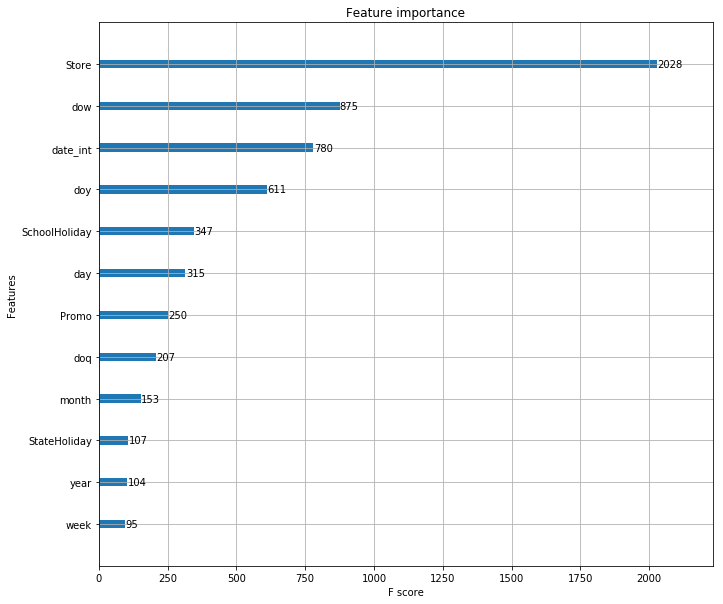

In [38]:
xgb_test(data=data_with_date.copy())

## get lagged features

In [39]:
stats_col = ['max','min','mean','median','skew','std']

In [40]:
quarter_data = data_with_date.groupby(['Store','year','quarter'],
                       as_index=False)['Sales'].agg({
    'quarter_1lag_{}'.format(stats_col[0]):stats_col[0],
    'quarter_1lag_{}'.format(stats_col[1]):stats_col[1],
    'quarter_1lag_{}'.format(stats_col[2]):stats_col[2],
    'quarter_1lag_{}'.format(stats_col[3]):stats_col[3],
    'quarter_1lag_{}'.format(stats_col[4]):stats_col[4],
    'quarter_1lag_{}'.format(stats_col[5]):stats_col[5]
})

In [41]:
quarter_data.head()

Store  year  quarter  quarter_1lag_max  quarter_1lag_min  \
0      1  2013        1            7675.0            3725.0   
1      1  2013        2            7893.0            2952.0   
2      1  2013        3            6377.0            3096.0   
3      1  2013        4            9528.0            2362.0   
4      1  2014        1            6198.0            3136.0   

   quarter_1lag_mean  quarter_1lag_median  quarter_1lag_skew  quarter_1lag_std  
0        5318.280000               5350.0           0.409342        933.822507  
1        4789.657534               4766.0           0.626813        844.214119  
2        4496.443038               4275.0           0.478701        769.803134  
3        5097.434211               4983.0           0.908986       1345.947986  
4        4548.881579               4573.0           0.168144        779.330396

In [42]:
quarter_data = quarter_data.sort_values(by=['Store','year','quarter'])

In [43]:
quarter_data.head(10)

Store  year  quarter  quarter_1lag_max  quarter_1lag_min  \
0      1  2013        1            7675.0            3725.0   
1      1  2013        2            7893.0            2952.0   
2      1  2013        3            6377.0            3096.0   
3      1  2013        4            9528.0            2362.0   
4      1  2014        1            6198.0            3136.0   
5      1  2014        2            6803.0            2749.0   
6      1  2014        3            5655.0            2462.0   
7      1  2014        4            9331.0            2605.0   
8      1  2015        1            6714.0            3136.0   
9      1  2015        2            6816.0            3037.0   

   quarter_1lag_mean  quarter_1lag_median  quarter_1lag_skew  quarter_1lag_std  
0        5318.280000               5350.0           0.409342        933.822507  
1        4789.657534               4766.0           0.626813        844.214119  
2        4496.443038               4275.0           0.478701        769.803134  
3        5097.434211               4983.0           0.908986       1345.947986  
4        4548.881579               4573.0           0.168144        779.330396  
5        4734.888889               4747.5           0.256295        935.561044  
6        4303.873418               4174.0           0.109879        707.312780  
7        5352.302632               4965.0           0.660534       1388.523686  
8        4541.500000               4557.5           0.444494        784.448316  
9        4526.194444               4266.0           0.600993        899.685573

In [44]:
for col in quarter_data.columns.tolist():
    if col == 'Store':
        quarter_data['{}_Shifted'.format(col)] = quarter_data[col].shift(1)
    elif col in ['year','quarter']:
        continue
    else:
        quarter_data[col] = quarter_data[col].shift(1)

In [45]:
quarter_data.head()

Store  year  quarter  quarter_1lag_max  quarter_1lag_min  \
0      1  2013        1               NaN               NaN   
1      1  2013        2            7675.0            3725.0   
2      1  2013        3            7893.0            2952.0   
3      1  2013        4            6377.0            3096.0   
4      1  2014        1            9528.0            2362.0   

   quarter_1lag_mean  quarter_1lag_median  quarter_1lag_skew  \
0                NaN                  NaN                NaN   
1        5318.280000               5350.0           0.409342   
2        4789.657534               4766.0           0.626813   
3        4496.443038               4275.0           0.478701   
4        5097.434211               4983.0           0.908986   

   quarter_1lag_std  Store_Shifted  
0               NaN            NaN  
1        933.822507            1.0  
2        844.214119            1.0  
3        769.803134            1.0  
4       1345.947986            1.0

In [46]:
def get_zeros(data):
    if data.Store!=data.Store_Shifted:
        for col in ['quarter_1lag_{}'.format(i) for i in stats_col]:
            data[col]=0
    data.drop('Store_Shifted',inplace=True)
    return data

In [47]:
quarter_data.iloc[:3].apply(get_zeros,axis=1)

Store    year  quarter  quarter_1lag_max  quarter_1lag_min  \
0    1.0  2013.0      1.0               0.0               0.0   
1    1.0  2013.0      2.0            7675.0            3725.0   
2    1.0  2013.0      3.0            7893.0            2952.0   

   quarter_1lag_mean  quarter_1lag_median  quarter_1lag_skew  quarter_1lag_std  
0           0.000000                  0.0           0.000000          0.000000  
1        5318.280000               5350.0           0.409342        933.822507  
2        4789.657534               4766.0           0.626813        844.214119

In [48]:
quarter_data = quarter_data.apply(get_zeros,axis=1)

In [49]:
data_with_date.shape

(879485, 19)

In [50]:
data_with_date = data_with_date.merge(quarter_data,how='inner',
                                     on=['Store','year','quarter'])

In [51]:
data_with_date.head()

Date  DayOfWeek   Id  Open  Promo   Sales  SchoolHoliday  \
0  2015-07-31          5  0.0   1.0      1  5263.0              1   
1  2015-07-30          4  0.0   1.0      1  5020.0              1   
2  2015-07-29          3  0.0   1.0      1  4782.0              1   
3  2015-07-28          2  0.0   1.0      1  5011.0              1   
4  2015-07-27          1  0.0   1.0      1  6102.0              1   

  StateHoliday Store  year        ...         week  date_int   doq half_year  \
0            0     1  2015        ...           31       942  31.0         1   
1            0     1  2015        ...           31       941  30.0         1   
2            0     1  2015        ...           31       940  29.0         1   
3            0     1  2015        ...           31       939  28.0         1   
4            0     1  2015        ...           31       938  27.0         1   

   quarter_1lag_max  quarter_1lag_min  quarter_1lag_mean  quarter_1lag_median  \
0            6816.0            3037.0        4526.194444               4266.0   
1            6816.0            3037.0        4526.194444               4266.0   
2            6816.0            3037.0        4526.194444               4266.0   
3            6816.0            3037.0        4526.194444               4266.0   
4            6816.0            3037.0        4526.194444               4266.0   

   quarter_1lag_skew  quarter_1lag_std  
0           0.600993        899.685573  
1           0.600993        899.685573  
2           0.600993        899.685573  
3           0.600993        899.685573  
4           0.600993        899.685573  

[5 rows x 25 columns]

In [52]:
data_with_date.columns

Index(['Date', 'DayOfWeek', 'Id', 'Open', 'Promo', 'Sales', 'SchoolHoliday',
       'StateHoliday', 'Store', 'year', 'month', 'dow', 'doy', 'quarter',
       'day', 'week', 'date_int', 'doq', 'half_year', 'quarter_1lag_max',
       'quarter_1lag_min', 'quarter_1lag_mean', 'quarter_1lag_median',
       'quarter_1lag_skew', 'quarter_1lag_std'],
      dtype='object')

rmspe is 0.2279


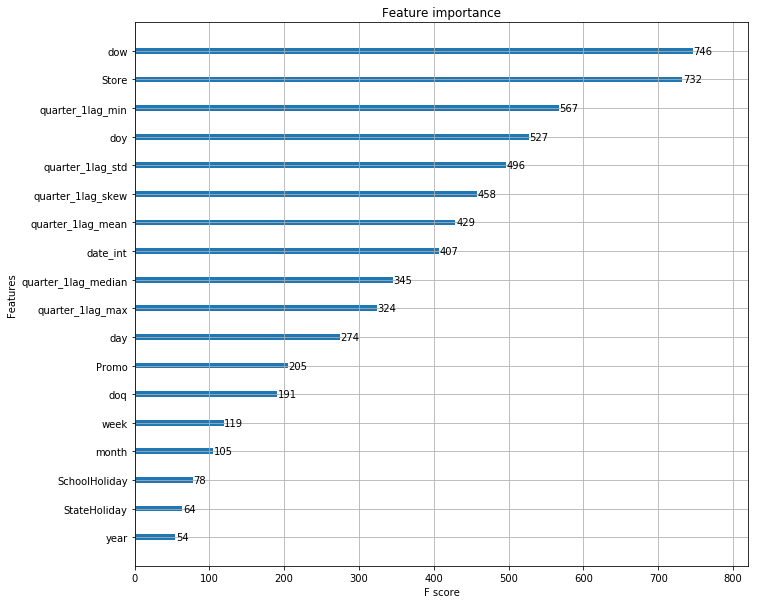

In [53]:
xgb_test(data=data_with_date.copy())

## half year stats

In [54]:
half_data = data_with_date.groupby(['Store','year','half_year'],
                                  as_index=False
                                  )['Sales'].agg({
    'half_year_1lag_{}'.format(stats_col[0]):stats_col[0],
    'half_year_1lag_{}'.format(stats_col[1]):stats_col[1],
    'half_year_1lag_{}'.format(stats_col[2]):stats_col[2],
    'half_year_1lag_{}'.format(stats_col[3]):stats_col[3],
    'half_year_1lag_{}'.format(stats_col[4]):stats_col[4],
    'half_year_1lag_{}'.format(stats_col[5]):stats_col[5],
    }
)

In [55]:
half_data.head()

Store  year  half_year  half_year_1lag_max  half_year_1lag_min  \
0      1  2013          0              7893.0              2952.0   
1      1  2013          1              9528.0              2362.0   
2      1  2014          0              6803.0              2749.0   
3      1  2014          1              9331.0              2462.0   
4      1  2015          0              6816.0              3037.0   

   half_year_1lag_mean  half_year_1lag_median  half_year_1lag_skew  \
0          5057.540541                 4998.5             0.516646   
1          4791.122581                 4600.0             1.202419   
2          4639.371622                 4600.5             0.278167   
3          4817.941935                 4611.0             1.125527   
4          4534.054054                 4445.0             0.530738   

   half_year_1lag_std  
0          926.486615  
1         1128.387076  
2          861.004770  
3         1211.955516  
4          839.624234

In [56]:
half_data = half_data.sort_values(by=['Store','year','half_year'])

In [57]:
for col in half_data.columns.tolist():
    if col == 'Store':
        half_data['Store_shifted'] = half_data.Store.shift(1)
    elif col in ['year','half_year']:
        continue
    else:
        half_data[col] = half_data[col].shift(1)

In [58]:
half_data.head()

Store  year  half_year  half_year_1lag_max  half_year_1lag_min  \
0      1  2013          0                 NaN                 NaN   
1      1  2013          1              7893.0              2952.0   
2      1  2014          0              9528.0              2362.0   
3      1  2014          1              6803.0              2749.0   
4      1  2015          0              9331.0              2462.0   

   half_year_1lag_mean  half_year_1lag_median  half_year_1lag_skew  \
0                  NaN                    NaN                  NaN   
1          5057.540541                 4998.5             0.516646   
2          4791.122581                 4600.0             1.202419   
3          4639.371622                 4600.5             0.278167   
4          4817.941935                 4611.0             1.125527   

   half_year_1lag_std  Store_shifted  
0                 NaN            NaN  
1          926.486615            1.0  
2         1128.387076            1.0  
3          861.004770            1.0  
4         1211.955516            1.0

In [59]:
def get_zeros(data):
    if data.Store!=data.Store_shifted:
        for col in ['half_year_1lag_{}'.format(i) for i in stats_col]:
            data[col]=0
    data.drop('Store_shifted',inplace=True)
    return data

In [60]:
half_data.iloc[:3].apply(get_zeros,axis=1)

Store    year  half_year  half_year_1lag_max  half_year_1lag_min  \
0    1.0  2013.0        0.0                 0.0                 0.0   
1    1.0  2013.0        1.0              7893.0              2952.0   
2    1.0  2014.0        0.0              9528.0              2362.0   

   half_year_1lag_mean  half_year_1lag_median  half_year_1lag_skew  \
0             0.000000                    0.0             0.000000   
1          5057.540541                 4998.5             0.516646   
2          4791.122581                 4600.0             1.202419   

   half_year_1lag_std  
0            0.000000  
1          926.486615  
2         1128.387076

In [61]:
half_data = half_data.apply(get_zeros,axis=1)

In [62]:
data_with_date.shape

(879485, 25)

In [63]:
data['full'].shape

(1058297, 9)

In [64]:
data_with_date = data_with_date.merge(half_data,how='inner',
                                     on=['Store','year','half_year'])

In [65]:
data_with_date.shape

(879485, 31)

In [66]:
data_with_date.head()

Date  DayOfWeek   Id  Open  Promo   Sales  SchoolHoliday  \
0  2015-07-31          5  0.0   1.0      1  5263.0              1   
1  2015-07-30          4  0.0   1.0      1  5020.0              1   
2  2015-07-29          3  0.0   1.0      1  4782.0              1   
3  2015-07-28          2  0.0   1.0      1  5011.0              1   
4  2015-07-27          1  0.0   1.0      1  6102.0              1   

  StateHoliday Store  year         ...          quarter_1lag_mean  \
0            0     1  2015         ...                4526.194444   
1            0     1  2015         ...                4526.194444   
2            0     1  2015         ...                4526.194444   
3            0     1  2015         ...                4526.194444   
4            0     1  2015         ...                4526.194444   

   quarter_1lag_median  quarter_1lag_skew quarter_1lag_std  \
0               4266.0           0.600993       899.685573   
1               4266.0           0.600993       899.685573   
2               4266.0           0.600993       899.685573   
3               4266.0           0.600993       899.685573   
4               4266.0           0.600993       899.685573   

   half_year_1lag_max  half_year_1lag_min  half_year_1lag_mean  \
0              6816.0              3037.0          4534.054054   
1              6816.0              3037.0          4534.054054   
2              6816.0              3037.0          4534.054054   
3              6816.0              3037.0          4534.054054   
4              6816.0              3037.0          4534.054054   

   half_year_1lag_median half_year_1lag_skew  half_year_1lag_std  
0                 4445.0            0.530738          839.624234  
1                 4445.0            0.530738          839.624234  
2                 4445.0            0.530738          839.624234  
3                 4445.0            0.530738          839.624234  
4                 4445.0            0.530738          839.624234  

[5 rows x 31 columns]

rmspe is 0.1982


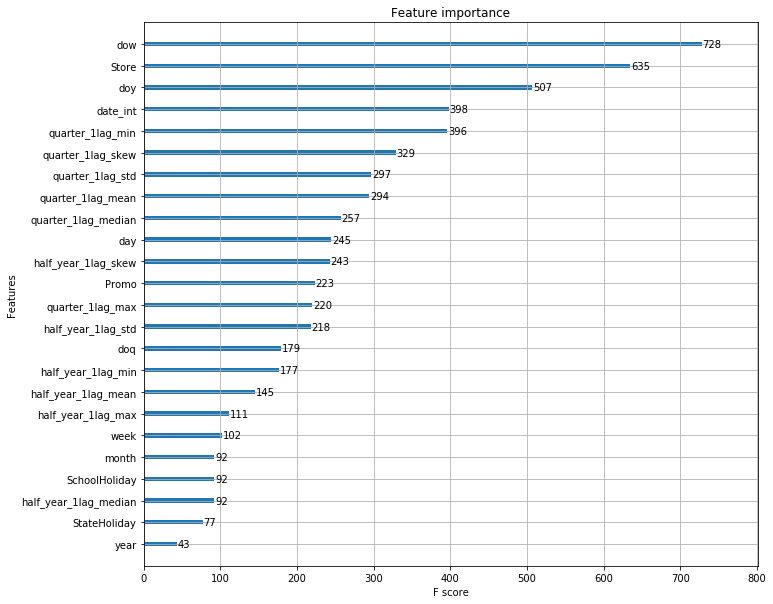

In [67]:
xgb_test(data_with_date.copy())

## holidays sales in quarters

In [68]:
holi_quarter = data_with_date.groupby(['Store','year','quarter',
                                      'SchoolHoliday'],as_index=False
                                     )['Sales'].agg(
    {
        'scholi_sales_quarter_1lag_{}'.format(stats_col[0]):stats_col[0],
        'scholi_sales_quarter_1lag_{}'.format(stats_col[1]):stats_col[1],
        'scholi_sales_quarter_1lag_{}'.format(stats_col[2]):stats_col[2],
        'scholi_sales_quarter_1lag_{}'.format(stats_col[3]):stats_col[3],
        'scholi_sales_quarter_1lag_{}'.format(stats_col[4]):stats_col[4],
        'scholi_sales_quarter_1lag_{}'.format(stats_col[5]):stats_col[5],
    }
)

In [69]:
holi_quarter.head()

Store  year  quarter  SchoolHoliday  scholi_sales_quarter_1lag_max  \
0      1  2013        1              0                         7675.0   
1      1  2013        1              1                         7285.0   
2      1  2013        2              0                         7893.0   
3      1  2013        2              1                         5484.0   
4      1  2013        3              0                         5893.0   

   scholi_sales_quarter_1lag_min  scholi_sales_quarter_1lag_mean  \
0                         3725.0                     5228.564516   
1                         4327.0                     5746.153846   
2                         2952.0                     4794.971014   
3                         4293.0                     4698.000000   
4                         3096.0                     4518.372093   

   scholi_sales_quarter_1lag_median  scholi_sales_quarter_1lag_skew  \
0                            5249.0                        0.405104   
1                            5530.0                        0.223335   
2                            4773.0                        0.604402   
3                            4507.5                        1.629075   
4                            4481.0                        0.195782   

   scholi_sales_quarter_1lag_std  
0                     894.083900  
1                    1036.349591  
2                     860.887469  
3                     542.221972  
4                     771.208422

In [70]:
for col in holi_quarter.columns.tolist():
    print(col,sum(holi_quarter[col].isnull()))

Store 0
year 0
quarter 0
SchoolHoliday 0
scholi_sales_quarter_1lag_max 0
scholi_sales_quarter_1lag_min 0
scholi_sales_quarter_1lag_mean 0
scholi_sales_quarter_1lag_median 0
scholi_sales_quarter_1lag_skew 71
scholi_sales_quarter_1lag_std 0


In [71]:
holi_quarter.fillna(0,inplace=True)

In [72]:
for col in holi_quarter.columns.tolist():
    print(col,sum(holi_quarter[col].isnull()))

Store 0
year 0
quarter 0
SchoolHoliday 0
scholi_sales_quarter_1lag_max 0
scholi_sales_quarter_1lag_min 0
scholi_sales_quarter_1lag_mean 0
scholi_sales_quarter_1lag_median 0
scholi_sales_quarter_1lag_skew 0
scholi_sales_quarter_1lag_std 0


In [73]:
holi_quarter = holi_quarter.sort_values(by=['Store','year','quarter',
                                           'SchoolHoliday'])

In [74]:
yes_holi_quarter = holi_quarter[holi_quarter.SchoolHoliday==1]
no_holi_quarter = holi_quarter[holi_quarter.SchoolHoliday==0]

In [75]:
yes_holi_quarter.shape,no_holi_quarter.shape

((11896, 10), (11900, 10))

In [76]:
yes_holi_quarter = yes_holi_quarter.sort_values(by=['Store','year',
                                                   'quarter'])
no_holi_quarter = no_holi_quarter.sort_values(by=['Store','year','quarter'])

In [77]:
yes_holi_quarter.head(2)

Store  year  quarter  SchoolHoliday  scholi_sales_quarter_1lag_max  \
1      1  2013        1              1                         7285.0   
3      1  2013        2              1                         5484.0   

   scholi_sales_quarter_1lag_min  scholi_sales_quarter_1lag_mean  \
1                         4327.0                     5746.153846   
3                         4293.0                     4698.000000   

   scholi_sales_quarter_1lag_median  scholi_sales_quarter_1lag_skew  \
1                            5530.0                        0.223335   
3                            4507.5                        1.629075   

   scholi_sales_quarter_1lag_std  
1                    1036.349591  
3                     542.221972

In [78]:
for col in yes_holi_quarter.columns.tolist():
    if col == 'Store':
        yes_holi_quarter['Store_Shifted'] = yes_holi_quarter.Store.shift(1)
    elif col in ['year','quarter','SchoolHoliday']:
        continue
    else:
        yes_holi_quarter['yes_{}'.format(col)]=yes_holi_quarter[col].shift(1)
        yes_holi_quarter.drop(col,axis=1,inplace=True)

In [79]:
yes_holi_quarter.head()

Store  year  quarter  SchoolHoliday  Store_Shifted  \
1      1  2013        1              1            NaN   
3      1  2013        2              1            1.0   
5      1  2013        3              1            1.0   
7      1  2013        4              1            1.0   
9      1  2014        1              1            1.0   

   yes_scholi_sales_quarter_1lag_max  yes_scholi_sales_quarter_1lag_min  \
1                                NaN                                NaN   
3                             7285.0                             4327.0   
5                             5484.0                             4293.0   
7                             6377.0                             3257.0   
9                             9528.0                             2362.0   

   yes_scholi_sales_quarter_1lag_mean  yes_scholi_sales_quarter_1lag_median  \
1                                 NaN                                   NaN   
3                         5746.153846                                5530.0   
5                         4698.000000                                4507.5   
7                         4470.250000                                4248.0   
9                         4551.470588                                4044.0   

   yes_scholi_sales_quarter_1lag_skew  yes_scholi_sales_quarter_1lag_std  
1                                 NaN                                NaN  
3                            0.223335                        1036.349591  
5                            1.629075                         542.221972  
7                            0.836234                         778.224293  
9                            1.631196                        1762.078181

In [80]:
for col in no_holi_quarter.columns.tolist():
    if col == 'Store':
        no_holi_quarter['Store_Shifted']=no_holi_quarter.Store.shift(1)
    elif col in ['year','quarter','SchoolHoliday']:
        continue
    else:
        no_holi_quarter['no_{}'.format(col)]=no_holi_quarter[col].shift(1)
        no_holi_quarter.drop(col,axis=1,inplace=True)

In [81]:
no_holi_quarter.head(2)

Store  year  quarter  SchoolHoliday  Store_Shifted  \
0      1  2013        1              0            NaN   
2      1  2013        2              0            1.0   

   no_scholi_sales_quarter_1lag_max  no_scholi_sales_quarter_1lag_min  \
0                               NaN                               NaN   
2                            7675.0                            3725.0   

   no_scholi_sales_quarter_1lag_mean  no_scholi_sales_quarter_1lag_median  \
0                                NaN                                  NaN   
2                        5228.564516                               5249.0   

   no_scholi_sales_quarter_1lag_skew  no_scholi_sales_quarter_1lag_std  
0                                NaN                               NaN  
2                           0.405104                          894.0839

In [82]:
def get_zeros(data,yesno):
    if data.loc['Store']!=data.loc['Store_Shifted']:
        for col in ['{}_scholi_sales_quarter_1lag_{}'.format(
        yesno,i) for i in stats_col]:
            data[col]=0
    data.drop(['Store_Shifted','SchoolHoliday'],inplace=True)
    return data

In [83]:
get_zeros(data=no_holi_quarter.iloc[2],yesno='no')

C:\Users\Xufeng\Anaconda3\lib\site-packages\pandas\core\generic.py:2184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


Store                                     1.000000
year                                   2013.000000
quarter                                   3.000000
no_scholi_sales_quarter_1lag_max       7893.000000
no_scholi_sales_quarter_1lag_min       2952.000000
no_scholi_sales_quarter_1lag_mean      4794.971014
no_scholi_sales_quarter_1lag_median    4773.000000
no_scholi_sales_quarter_1lag_skew         0.604402
no_scholi_sales_quarter_1lag_std        860.887469
Name: 4, dtype: float64

In [84]:
no_holi_quarter.iloc[:3].apply(lambda x:get_zeros(data=x,yesno='no'),axis=1)

Store    year  quarter  no_scholi_sales_quarter_1lag_max  \
0    1.0  2013.0      1.0                               0.0   
2    1.0  2013.0      2.0                            7675.0   
4    1.0  2013.0      3.0                            7893.0   

   no_scholi_sales_quarter_1lag_min  no_scholi_sales_quarter_1lag_mean  \
0                               0.0                           0.000000   
2                            3725.0                        5228.564516   
4                            2952.0                        4794.971014   

   no_scholi_sales_quarter_1lag_median  no_scholi_sales_quarter_1lag_skew  \
0                                  0.0                           0.000000   
2                               5249.0                           0.405104   
4                               4773.0                           0.604402   

   no_scholi_sales_quarter_1lag_std  
0                          0.000000  
2                        894.083900  
4                        860.887469

In [85]:
no_holi_quarter = no_holi_quarter.apply(lambda x:get_zeros(data=x,
                                                           yesno='no')
                                       ,axis=1)
yes_holi_quarter = yes_holi_quarter.apply(lambda x:get_zeros(data=x,
                                                            yesno='yes'),
                                         axis=1)

In [86]:
yes_holi_quarter.head(2)

Store    year  quarter  yes_scholi_sales_quarter_1lag_max  \
1    1.0  2013.0      1.0                                0.0   
3    1.0  2013.0      2.0                             7285.0   

   yes_scholi_sales_quarter_1lag_min  yes_scholi_sales_quarter_1lag_mean  \
1                                0.0                            0.000000   
3                             4327.0                         5746.153846   

   yes_scholi_sales_quarter_1lag_median  yes_scholi_sales_quarter_1lag_skew  \
1                                   0.0                            0.000000   
3                                5530.0                            0.223335   

   yes_scholi_sales_quarter_1lag_std  
1                           0.000000  
3                        1036.349591

In [87]:
no_holi_quarter.head(2)

Store    year  quarter  no_scholi_sales_quarter_1lag_max  \
0    1.0  2013.0      1.0                               0.0   
2    1.0  2013.0      2.0                            7675.0   

   no_scholi_sales_quarter_1lag_min  no_scholi_sales_quarter_1lag_mean  \
0                               0.0                           0.000000   
2                            3725.0                        5228.564516   

   no_scholi_sales_quarter_1lag_median  no_scholi_sales_quarter_1lag_skew  \
0                                  0.0                           0.000000   
2                               5249.0                           0.405104   

   no_scholi_sales_quarter_1lag_std  
0                            0.0000  
2                          894.0839

In [88]:
data_with_date = data_with_date.merge(no_holi_quarter,how='inner',
                                     on=['Store','year','quarter'])
data_with_date = data_with_date.merge(yes_holi_quarter,how='inner',
                                     on=['Store','year','quarter'])

In [89]:
data_with_date.head()

Date  DayOfWeek   Id  Open  Promo   Sales  SchoolHoliday  \
0  2015-07-31          5  0.0   1.0      1  5263.0              1   
1  2015-07-30          4  0.0   1.0      1  5020.0              1   
2  2015-07-29          3  0.0   1.0      1  4782.0              1   
3  2015-07-28          2  0.0   1.0      1  5011.0              1   
4  2015-07-27          1  0.0   1.0      1  6102.0              1   

  StateHoliday Store  year                ...                  \
0            0     1  2015                ...                   
1            0     1  2015                ...                   
2            0     1  2015                ...                   
3            0     1  2015                ...                   
4            0     1  2015                ...                   

   no_scholi_sales_quarter_1lag_mean  no_scholi_sales_quarter_1lag_median  \
0                        4467.907692                               4276.0   
1                        4467.907692                               4276.0   
2                        4467.907692                               4276.0   
3                        4467.907692                               4276.0   
4                        4467.907692                               4276.0   

   no_scholi_sales_quarter_1lag_skew no_scholi_sales_quarter_1lag_std  \
0                           0.271761                       797.736774   
1                           0.271761                       797.736774   
2                           0.271761                       797.736774   
3                           0.271761                       797.736774   
4                           0.271761                       797.736774   

   yes_scholi_sales_quarter_1lag_max  yes_scholi_sales_quarter_1lag_min  \
0                             6816.0                             3467.0   
1                             6816.0                             3467.0   
2                             6816.0                             3467.0   
3                             6816.0                             3467.0   
4                             6816.0                             3467.0   

   yes_scholi_sales_quarter_1lag_mean  yes_scholi_sales_quarter_1lag_median  \
0                         5067.428571                                4194.0   
1                         5067.428571                                4194.0   
2                         5067.428571                                4194.0   
3                         5067.428571                                4194.0   
4                         5067.428571                                4194.0   

  yes_scholi_sales_quarter_1lag_skew  yes_scholi_sales_quarter_1lag_std  
0                           0.260618                        1552.947827  
1                           0.260618                        1552.947827  
2                           0.260618                        1552.947827  
3                           0.260618                        1552.947827  
4                           0.260618                        1552.947827  

[5 rows x 43 columns]

rmspe is 0.2433


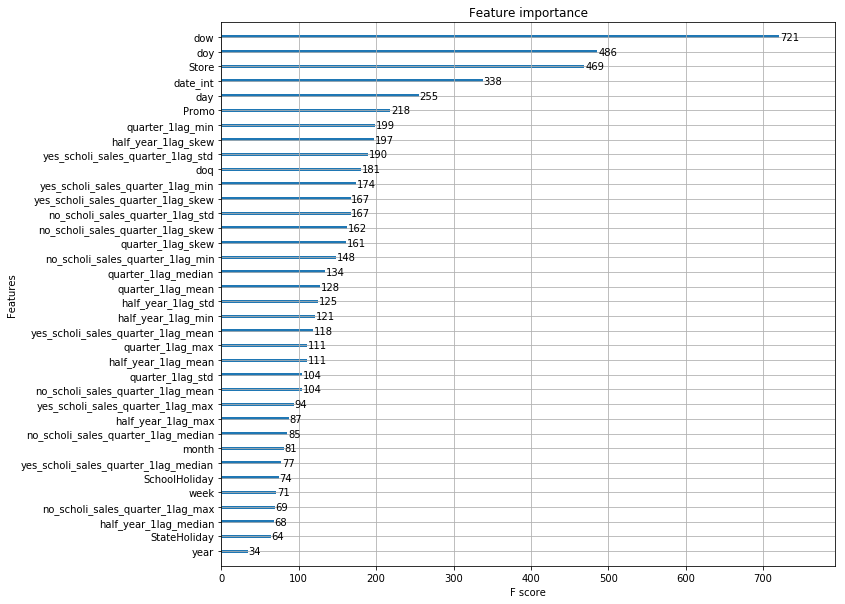

In [90]:
xgb_test(data_with_date.copy())

## stateholiday

In [91]:
data_with_date.StateHoliday = data_with_date.StateHoliday.apply(lambda 
                                                                x:'0' if
                                                               x==0 else x)
stholi_year = data_with_date.groupby(['Store','year',
                                        'StateHoliday'],
                                       as_index=False)['Sales'].agg(
    {
        'stholi_sales_year_1lag_{}'.format(stats_col[0]):stats_col[0],
        'stholi_sales_year_1lag_{}'.format(stats_col[1]):stats_col[1],
        'stholi_sales_year_1lag_{}'.format(stats_col[2]):stats_col[2],
        'stholi_sales_year_1lag_{}'.format(stats_col[3]):stats_col[3],
        'stholi_sales_year_1lag_{}'.format(stats_col[4]):stats_col[4],
        'stholi_sales_year_1lag_{}'.format(stats_col[5]):stats_col[5],
    }
)

In [92]:
stholi_year.head()

Store  year StateHoliday  stholi_sales_year_1lag_max  \
0      1  2013            0                      9528.0   
1      1  2014            0                      9331.0   
2      1  2015            0                      6816.0   
3      2  2013            0                     10479.0   
4      2  2013            a                      2656.0   

   stholi_sales_year_1lag_min  stholi_sales_year_1lag_mean  \
0                      2362.0                  4921.254125   
1                      2462.0                  4730.719472   
2                         0.0                  3668.083333   
3                      1919.0                  4902.666667   
4                      2656.0                  2656.000000   

   stholi_sales_year_1lag_median  stholi_sales_year_1lag_skew  \
0                         4804.0                     0.876872   
1                         4607.0                     1.014289   
2                         4171.5                    -1.029133   
3                         4741.0                     0.494245   
4                         2656.0                          NaN   

   stholi_sales_year_1lag_std  
0                 1041.580685  
1                 1057.283698  
2                 1925.428064  
3                 1626.043253  
4                         NaN

In [93]:
stholi_year.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [94]:
for col in stholi_year.columns.tolist():
    print(col,stholi_year[col].isnull().sum())

Store 0
year 0
StateHoliday 0
stholi_sales_year_1lag_max 0
stholi_sales_year_1lag_min 0
stholi_sales_year_1lag_mean 0
stholi_sales_year_1lag_median 0
stholi_sales_year_1lag_skew 463
stholi_sales_year_1lag_std 364


In [95]:
stholi_year.fillna(0,inplace=True)

In [96]:
for col in stholi_year.columns.tolist():
    print(col,stholi_year[col].isnull().sum())

Store 0
year 0
StateHoliday 0
stholi_sales_year_1lag_max 0
stholi_sales_year_1lag_min 0
stholi_sales_year_1lag_mean 0
stholi_sales_year_1lag_median 0
stholi_sales_year_1lag_skew 0
stholi_sales_year_1lag_std 0


In [97]:
stholi_list = stholi_year.StateHoliday.unique().tolist()
stholi = {
    holi:
    stholi_year[stholi_year.StateHoliday==holi].drop_duplicates() for 
    holi in stholi_list
}

In [98]:
stholi['c'].shape,stholi_year[['Store','year',]].drop_duplicates().shape

((38, 9), (3345, 2))

In [99]:
for key in stholi.keys():
    stholi[key] = stholi[key].merge(stholi_year[['Store','year',]]
                                    .drop_duplicates(),
                                    how='right',
                                   on=['Store','year'])
    stholi[key].fillna(0,inplace=True)
    stholi[key].sort_values(by=['Store','year'],inplace=True)
    for col in stholi[key].columns.tolist():
        if col=='Store':
            stholi[key]['Store_Shifted'] = stholi[key].Store.shift(1)
        elif col in ['year','StateHoliday']:
            continue
        else:
            stholi[key][key+'_{}'.format(col)] = stholi[key][col].shift(1)
            stholi[key].drop(col,axis=1,inplace=True)
    stholi[key].drop('StateHoliday',axis=1,inplace=True)
    def get_zeros(data):
        if data.Store!=data.Store_Shifted:
            for col in [key+'_stholi_sales_year_1lag_{}'.
                       format(i) for i in stats_col]:
                data[col]=0
        data.drop('Store_Shifted',inplace=True)
        return data
    stholi[key] = stholi[key].apply(get_zeros,axis=1)

In [100]:
stholi['0'].head(3)

Store    year  0_stholi_sales_year_1lag_max  0_stholi_sales_year_1lag_min  \
0    1.0  2013.0                           0.0                           0.0   
1    1.0  2014.0                        9528.0                        2362.0   
2    1.0  2015.0                        9331.0                        2462.0   

   0_stholi_sales_year_1lag_mean  0_stholi_sales_year_1lag_median  \
0                       0.000000                              0.0   
1                    4921.254125                           4804.0   
2                    4730.719472                           4607.0   

   0_stholi_sales_year_1lag_skew  0_stholi_sales_year_1lag_std  
0                       0.000000                      0.000000  
1                       0.876872                   1041.580685  
2                       1.014289                   1057.283698

In [101]:
data_with_date.shape

(879358, 43)

In [102]:
data_with_date_ = data_with_date.copy()
for i in stholi.values():
    data_with_date_ = data_with_date_.merge(i,how='left',
                                            on=['Store','year'])

In [103]:
data_with_date_.isnull().sum().sum()

0

In [104]:
data_with_date = data_with_date_
del data_with_date_

rmspe is 0.2168


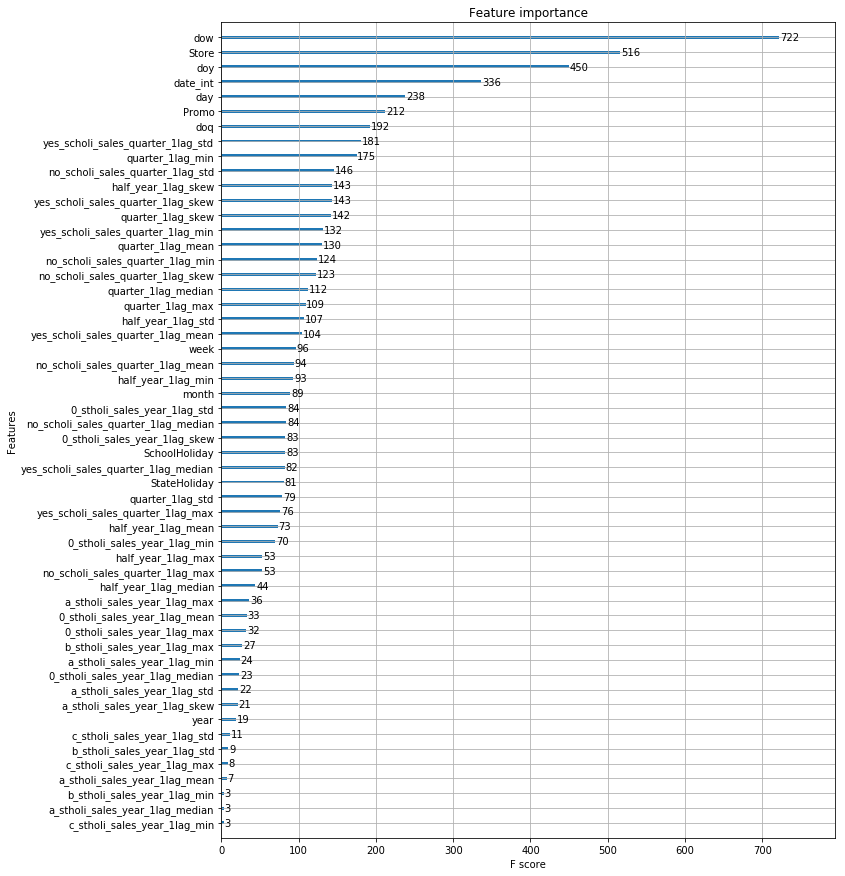

In [105]:
xgb_test(data_with_date.copy(),hight=15)

## holi notice

In [106]:
data_with_date.columns[:20]

Index(['Date', 'DayOfWeek', 'Id', 'Open', 'Promo', 'Sales', 'SchoolHoliday',
       'StateHoliday', 'Store', 'year', 'month', 'dow', 'doy', 'quarter',
       'day', 'week', 'date_int', 'doq', 'half_year', 'quarter_1lag_max'],
      dtype='object')

In [107]:
data_with_date.week.unique()

array([31, 30, 29, 28, 27, 38, 37, 36, 35, 34, 33, 32, 26, 25, 24, 23, 22,
       21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,
        4,  3,  2,  1, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40,
       39], dtype=int64)

In [108]:
holi_and_year = data_with_date[['year','week','SchoolHoliday'
                                ,'StateHoliday']]

In [109]:
len(data_with_date.StateHoliday[data_with_date.StateHoliday=='0'])

878422

In [110]:
 holi_and_year.loc[:,'StateHoliday'].head()

0    0
1    0
2    0
3    0
4    0
Name: StateHoliday, dtype: object

In [111]:
lbl = LabelEncoder()
holi_and_year.loc[:,'StateHoliday'] = lbl.fit_transform(
    holi_and_year.loc[:,'StateHoliday'])

C:\Users\Xufeng\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [112]:
holi_and_year.StateHoliday.unique()

array([0, 1, 2, 3], dtype=int64)

In [113]:
len(holi_and_year.StateHoliday[holi_and_year.StateHoliday==0])

878422

In [114]:
data_with_date.shape

(879358, 67)

In [115]:
holi_and_year.shape

(879358, 4)

In [116]:
holi_and_year = holi_and_year.groupby(['year','week'],as_index=False,
                     )['SchoolHoliday','StateHoliday'].sum()

In [117]:
holi_and_year.head()

year  week  SchoolHoliday  StateHoliday
0  2013     1           5539            19
1  2013     2            555             0
2  2013     3              0             0
3  2013     4              0             0
4  2013     5            128             0

In [118]:
def get_holi(data):
    if data.SchoolHoliday!=0 or data.StateHoliday!=0:
        return 1
    else:
        return 0

In [119]:
holi_and_year.iloc[:3].apply(get_holi,axis=1)

0    1
1    1
2    0
dtype: int64

In [120]:
holi_and_year['holi_this_week'] = holi_and_year.apply(get_holi,axis=1)

In [121]:
holi_and_year.drop(['SchoolHoliday','StateHoliday'],axis=1,inplace=True)

In [122]:
holi_and_year.sort_values(by=['year','week'],inplace=True)

In [123]:
holi_and_year['holi_next_week'] = holi_and_year.holi_this_week.shift(-1)
holi_and_year['holi_last_week'] = holi_and_year.holi_this_week.shift(1)

In [124]:
holi_and_year.head()

year  week  holi_this_week  holi_next_week  holi_last_week
0  2013     1               1             1.0             NaN
1  2013     2               1             0.0             1.0
2  2013     3               0             0.0             1.0
3  2013     4               0             1.0             0.0
4  2013     5               1             1.0             0.0

In [125]:
holi_and_year.fillna(0,inplace=True)

In [126]:
holi_and_year.head()

year  week  holi_this_week  holi_next_week  holi_last_week
0  2013     1               1             1.0             0.0
1  2013     2               1             0.0             1.0
2  2013     3               0             0.0             1.0
3  2013     4               0             1.0             0.0
4  2013     5               1             1.0             0.0

In [127]:
data_with_date.shape

(879358, 67)

In [128]:
data_with_date_ = data_with_date.copy()

In [129]:
data_with_date_ = data_with_date_.merge(holi_and_year,how='inner',
                                       on=['year','week'])

In [130]:
data_with_date_.shape

(879358, 70)

In [131]:
data_with_date = data_with_date_

## testing with xgboost

rmspe is 0.1760


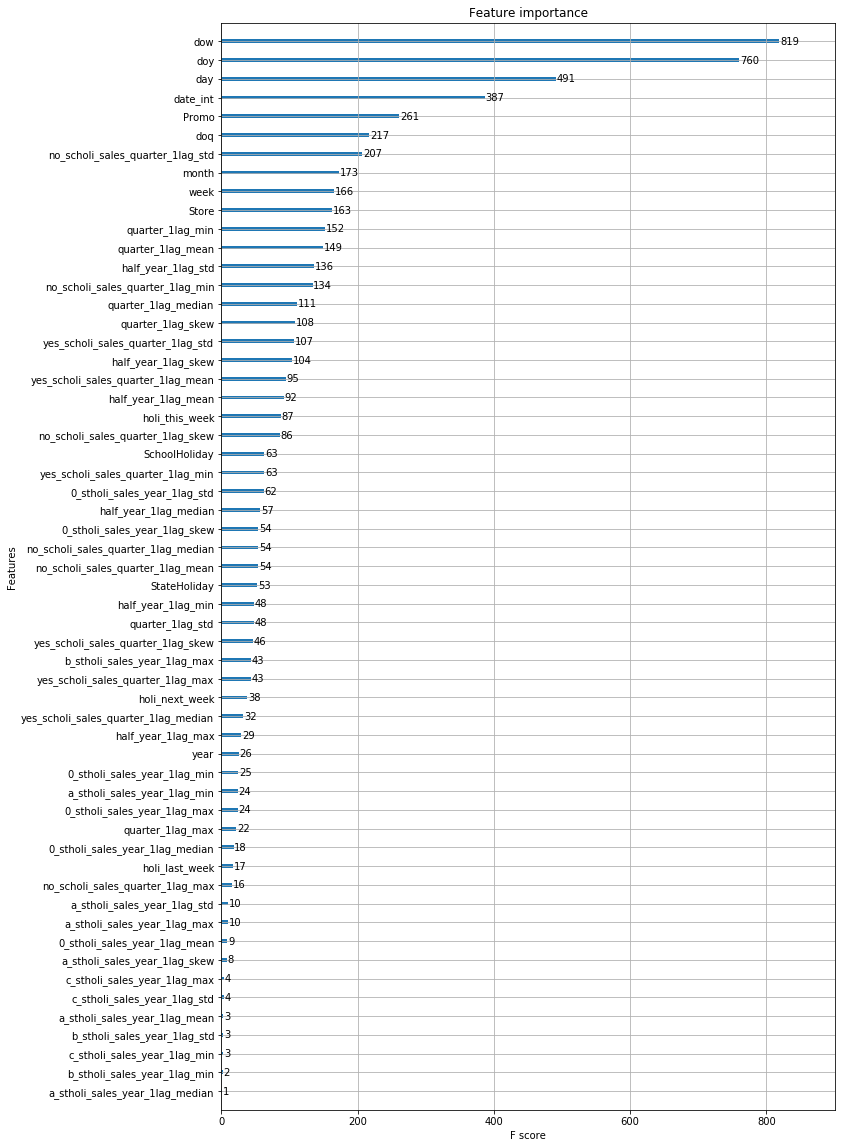

In [132]:
xgb_test(data_with_date.copy(),hight=20,eta=0.06)

## promo notice

In [133]:
promo_week = data_with_date[['Store','year','week','Promo']].copy()

In [134]:
promo_week.shape

(879358, 4)

In [135]:
promo_week = promo_week.groupby(['Store','year','week'],as_index=False,
                               )['Promo'].sum()

In [136]:
promo_week.shape

(151784, 4)

In [137]:
promo_week['Promo'] = promo_week.apply(lambda x:1 if x.Promo!=0 else 0, axis=1)

In [138]:
promo_week.shape

(151784, 4)

In [139]:
promo_week.head()

Store  year  week  Promo
0      1  2013     1      0
1      1  2013     2      1
2      1  2013     3      0
3      1  2013     4      1
4      1  2013     5      0

In [140]:
promo_week.sort_values(by=['Store','year','week'],inplace=True)

In [141]:
promo_week.head()

Store  year  week  Promo
0      1  2013     1      0
1      1  2013     2      1
2      1  2013     3      0
3      1  2013     4      1
4      1  2013     5      0

In [142]:
promo_week['promo_last_week'] = promo_week.Promo.shift(1)
promo_week['promo_next_week'] = promo_week.Promo.shift(-1)
promo_week['Store_Shifted'] = promo_week.Store.shift(1)

In [143]:
promo_week.head()

Store  year  week  Promo  promo_last_week  promo_next_week  Store_Shifted
0      1  2013     1      0              NaN              1.0            NaN
1      1  2013     2      1              0.0              0.0            1.0
2      1  2013     3      0              1.0              1.0            1.0
3      1  2013     4      1              0.0              0.0            1.0
4      1  2013     5      0              1.0              1.0            1.0

In [144]:
def get_zeros(data):
    if data.Store!=data.Store_Shifted:
        data.promo_last_week = data.Promo
        data.promo_next_week = data.Promo
    data.drop('Store_Shifted',inplace=True)
    return data

In [145]:
promo_week.shape

(151784, 7)

In [146]:
promo_week.iloc[:3].apply(get_zeros,axis=1)

Store    year  week  Promo  promo_last_week  promo_next_week
0    1.0  2013.0   1.0    0.0              0.0              0.0
1    1.0  2013.0   2.0    1.0              0.0              0.0
2    1.0  2013.0   3.0    0.0              1.0              1.0

In [147]:
promo_week = promo_week.apply(get_zeros,axis=1)

In [148]:
promo_week.fillna(1,inplace=True)

In [149]:
promo_week.rename(columns={'Promo':'promo_this_week'},inplace=True)

In [150]:
promo_week.head()

Store    year  week  promo_this_week  promo_last_week  promo_next_week
0    1.0  2013.0   1.0              0.0              0.0              0.0
1    1.0  2013.0   2.0              1.0              0.0              0.0
2    1.0  2013.0   3.0              0.0              1.0              1.0
3    1.0  2013.0   4.0              1.0              0.0              0.0
4    1.0  2013.0   5.0              0.0              1.0              1.0

In [151]:
promo_week.shape

(151784, 6)

In [152]:
data_with_date=data_with_date.merge(promo_week,how='inner',on=['Store','year','week'])

In [153]:
data_with_date.shape

(879358, 73)

In [154]:
data['full'].shape,data_with_date.shape

((1058297, 9), (879358, 73))

rmspe is 0.1731


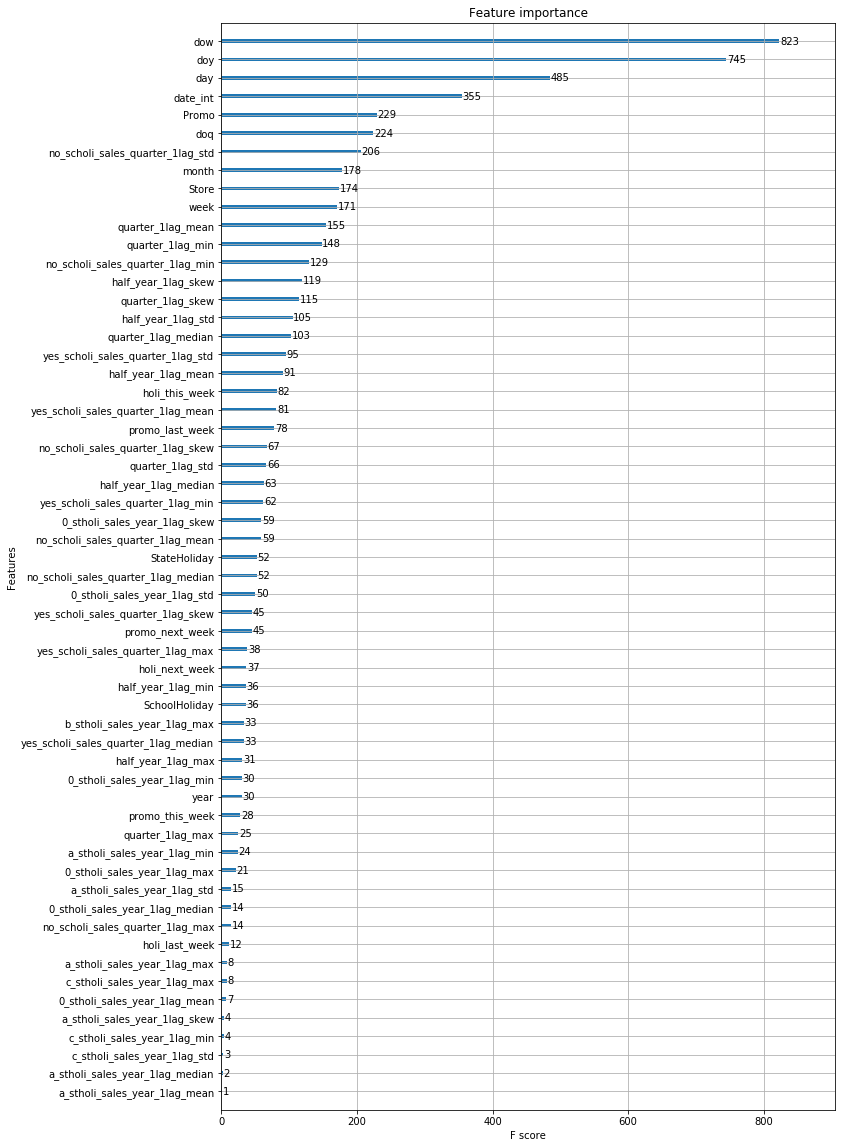

In [155]:
xgb_test(data=data_with_date.copy(),hight=20,eta=0.06)

In [156]:
weak_col = ['0_stholi_sales_year_1lag_max',
           '0_stholi_sales_year_1lag_min',
           '0_stholi_sales_year_1lag_mean',
            '0_stholi_sales_year_1lag_median',
            '0_stholi_sales_year_1lag_std',
            '0_stholi_sales_year_1lag_skew',
           'a_stholi_sales_year_1lag_std',
           'a_stholi_sales_year_1lag_max',
           'a_stholi_sales_year_1lag_min',
           'a_stholi_sales_year_1lag_skew',
           'a_stholi_sales_year_1lag_mean',
           'a_stholi_sales_year_1lag_median',
           'b_stholi_sales_year_1lag_max',
           'b_stholi_sales_year_1lag_min',
           'b_stholi_sales_year_1lag_mean',
            'b_stholi_sales_year_1lag_median',
            'b_stholi_sales_year_1lag_std',
            'b_stholi_sales_year_1lag_skew',
           'c_stholi_sales_year_1lag_max',
           'c_stholi_sales_year_1lag_min',
           'c_stholi_sales_year_1lag_mean',
            'c_stholi_sales_year_1lag_median',
            'c_stholi_sales_year_1lag_std',
            'c_stholi_sales_year_1lag_skew',]

rmspe is 0.1749


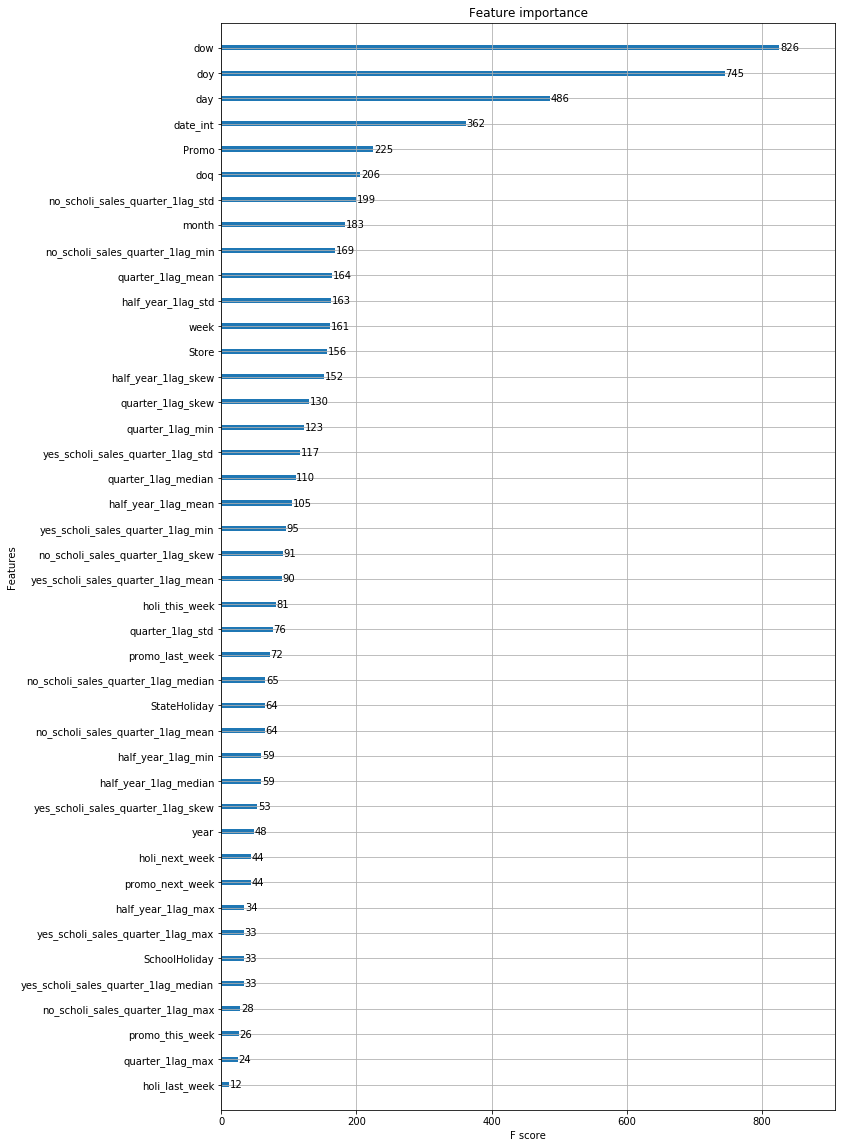

In [157]:
xgb_test(data=data_with_date.drop(weak_col,axis=1).copy(),
        hight=20,eta=0.06)

## promo progression

In [158]:
promo_prog = data_with_date[['Store','date_int','Promo']]

In [159]:
promo_prog.shape

(879358, 3)

In [160]:
promo_prog.head()

Store  date_int  Promo
0     1       942      1
1     1       941      1
2     1       940      1
3     1       939      1
4     1       938      1

In [161]:
promo_prog['day_before_promo'] = promo_prog.Promo.apply(lambda x:1 if x==0
                                                       else 0)

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [162]:
promo_prog.sort_values(by=['Store','date_int'],inplace=True)

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [163]:
promo_prog.head()

Store  date_int  Promo  day_before_promo
541535     1         2      0                 1
541534     1         3      0                 1
541533     1         4      0                 1
541532     1         5      0                 1
872912     1         7      1                 0

In [164]:
promo_prog['Promo_Shfited'] = promo_prog.Promo.shift(1)
promo_prog['Store_Shifted'] = promo_prog.Store.shift(1)

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [165]:
promo_prog.head(20)

Store  date_int  Promo  day_before_promo  Promo_Shfited Store_Shifted
541535     1         2      0                 1            NaN           NaN
541534     1         3      0                 1            0.0             1
541533     1         4      0                 1            0.0             1
541532     1         5      0                 1            0.0             1
872912     1         7      1                 0            0.0             1
872911     1         8      1                 0            1.0             1
872910     1         9      1                 0            1.0             1
872909     1        10      1                 0            1.0             1
872908     1        11      1                 0            1.0             1
872907     1        12      0                 1            1.0             1
866262     1        14      0                 1            0.0             1
866261     1        15      0                 1            0.0             1
866260     1        16      0                 1            0.0             1
866259     1        17      0                 1            0.0             1
866258     1        18      0                 1            0.0             1
866257     1        19      0                 1            0.0             1
859601     1        21      1                 0            0.0             1
859600     1        22      1                 0            1.0             1
859599     1        23      1                 0            1.0             1
859598     1        24      1                 0            1.0             1

In [166]:
grouper = []
group = 0
for row in promo_prog.iterrows():
    if row[1].Store!=row[1].Store_Shifted:
        group+=1
        grouper.append(group)
        continue
    if row[1].Promo!=row[1].Promo_Shfited:
        group+=1
        grouper.append(group)
    else:
        grouper.append(group)

In [167]:
promo_prog['grouper'] = grouper

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [168]:
promo_prog.head(2)

Store  date_int  Promo  day_before_promo  Promo_Shfited Store_Shifted  \
541535     1         2      0                 1            NaN           NaN   
541534     1         3      0                 1            0.0             1   

        grouper  
541535        1  
541534        1

In [169]:
promo_prog['promo_progress'] = promo_prog.groupby(['Store','grouper']
                                                  ,as_index=False
                                     )['Promo'].cumsum()
promo_prog['days_before_promo'] = promo_prog.groupby(['Store','grouper'],
                                                    as_index=False
                                                    )['day_before_promo'
                                                     ].cumsum()

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [170]:
promo_prog.shape

(879358, 9)

In [171]:
promo_prog.head(20)

Store  date_int  Promo  day_before_promo  Promo_Shfited Store_Shifted  \
541535     1         2      0                 1            NaN           NaN   
541534     1         3      0                 1            0.0             1   
541533     1         4      0                 1            0.0             1   
541532     1         5      0                 1            0.0             1   
872912     1         7      1                 0            0.0             1   
872911     1         8      1                 0            1.0             1   
872910     1         9      1                 0            1.0             1   
872909     1        10      1                 0            1.0             1   
872908     1        11      1                 0            1.0             1   
872907     1        12      0                 1            1.0             1   
866262     1        14      0                 1            0.0             1   
866261     1        15      0                 1            0.0             1   
866260     1        16      0                 1            0.0             1   
866259     1        17      0                 1            0.0             1   
866258     1        18      0                 1            0.0             1   
866257     1        19      0                 1            0.0             1   
859601     1        21      1                 0            0.0             1   
859600     1        22      1                 0            1.0             1   
859599     1        23      1                 0            1.0             1   
859598     1        24      1                 0            1.0             1   

        grouper  promo_progress  days_before_promo  
541535        1               0                  1  
541534        1               0                  2  
541533        1               0                  3  
541532        1               0                  4  
872912        2               1                  0  
872911        2               2                  0  
872910        2               3                  0  
872909        2               4                  0  
872908        2               5                  0  
872907        3               0                  1  
866262        3               0                  2  
866261        3               0                  3  
866260        3               0                  4  
866259        3               0                  5  
866258        3               0                  6  
866257        3               0                  7  
859601        4               1                  0  
859600        4               2                  0  
859599        4               3                  0  
859598        4               4                  0

In [172]:
promo_prog = promo_prog[['Store','date_int','promo_progress',
                        'days_before_promo']]

In [173]:
promo_prog.head()

Store  date_int  promo_progress  days_before_promo
541535     1         2               0                  1
541534     1         3               0                  2
541533     1         4               0                  3
541532     1         5               0                  4
872912     1         7               1                  0

In [174]:
data_with_date.shape

(879358, 73)

In [175]:
data_with_date = data_with_date.merge(promo_prog,how='left',
                                     on=['Store','date_int'])

In [176]:
data_with_date.shape

(879358, 75)

rmspe is 0.1648


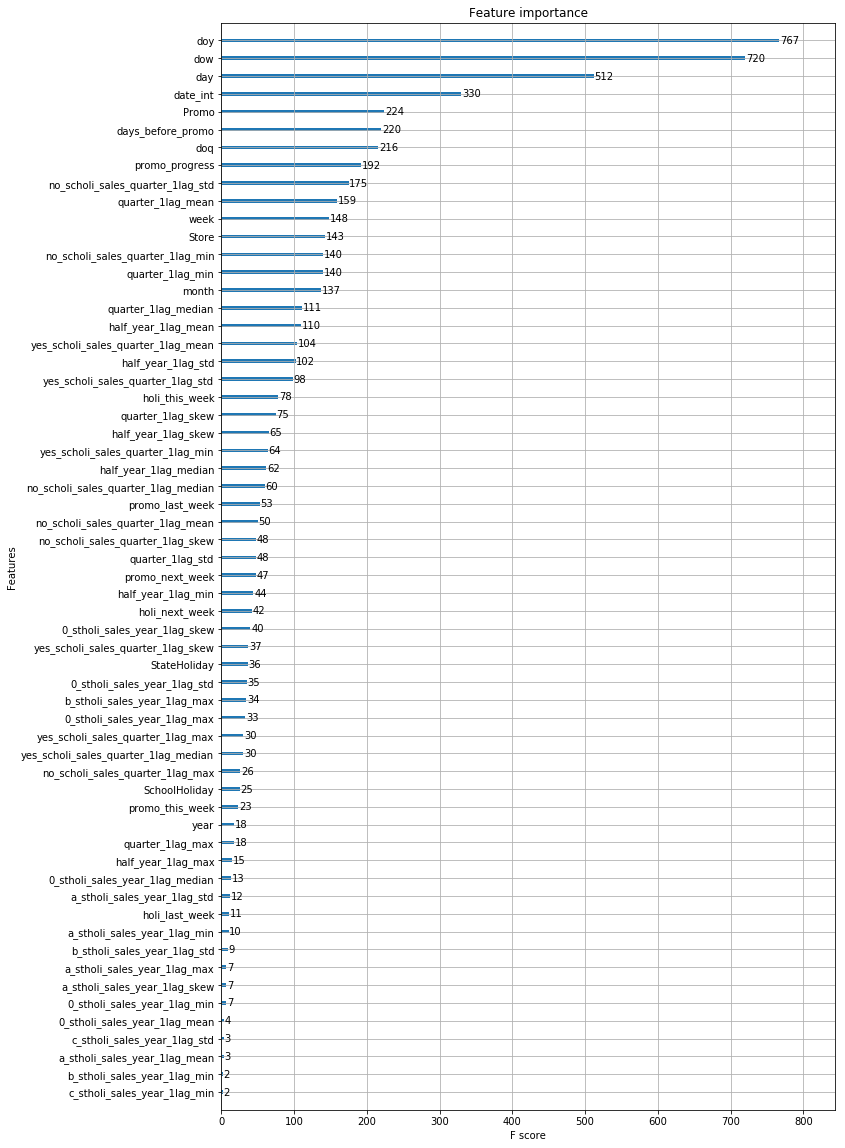

In [177]:
xgb_test(data = data_with_date,hight=20,eta=0.05)

In [178]:
eng_feat = {
    'sth_col':['0_stholi_sales_year_1lag_max',
           '0_stholi_sales_year_1lag_min',
           '0_stholi_sales_year_1lag_mean',
            '0_stholi_sales_year_1lag_median',
            '0_stholi_sales_year_1lag_std',
            '0_stholi_sales_year_1lag_skew',
           'a_stholi_sales_year_1lag_std',
           'a_stholi_sales_year_1lag_max',
           'a_stholi_sales_year_1lag_min',
           'a_stholi_sales_year_1lag_skew',
           'a_stholi_sales_year_1lag_mean',
           'a_stholi_sales_year_1lag_median',
           'b_stholi_sales_year_1lag_max',
           'b_stholi_sales_year_1lag_min',
           'b_stholi_sales_year_1lag_mean',
            'b_stholi_sales_year_1lag_median',
            'b_stholi_sales_year_1lag_std',
            'b_stholi_sales_year_1lag_skew',
           'c_stholi_sales_year_1lag_max',
           'c_stholi_sales_year_1lag_min',
           'c_stholi_sales_year_1lag_mean',
            'c_stholi_sales_year_1lag_median',
            'c_stholi_sales_year_1lag_std',
            'c_stholi_sales_year_1lag_skew'],
    'holi_notice':['holi_last_week','holi_this_week',
                   'holi_next_week'],
    'yesno_scholi':['yes_scholi_sales_quarter_1lag_max',
               'yes_scholi_sales_quarter_1lag_min',
               'yes_scholi_sales_quarter_1lag_mean',
               'yes_scholi_sales_quarter_1lag_median',
               'yes_scholi_sales_quarter_1lag_std',
               'yes_scholi_sales_quarter_1lag_skew',
               'no_scholi_sales_quarter_1lag_max',
               'no_scholi_sales_quarter_1lag_min',
               'no_scholi_sales_quarter_1lag_mean',
               'no_scholi_sales_quarter_1lag_median',
               'no_scholi_sales_quarter_1lag_std',
               'no_scholi_sales_quarter_1lag_skew'],
    'promo_notice':['promo_this_week','promo_next_week',
                    'promo_last_week'],
    'promo_prog':['promo_progress','days_before_promo']
}

rmspe is 0.1578


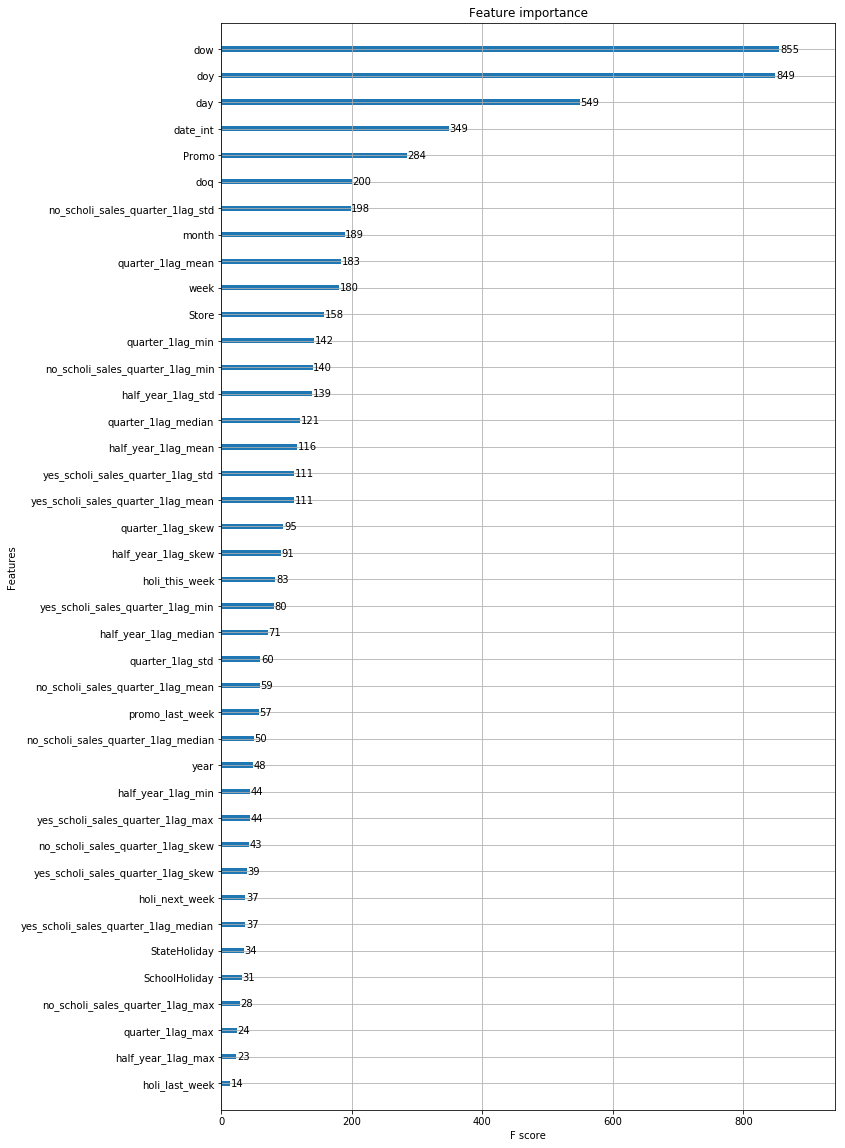

In [179]:
weak_col = eng_feat['sth_col']+eng_feat['promo_notice'][:2]+\
            eng_feat['promo_prog']
xgb_test(data=data_with_date.drop(weak_col,axis=1),
        hight=20,eta=0.045)

## cat test

rmspe is 0.1739


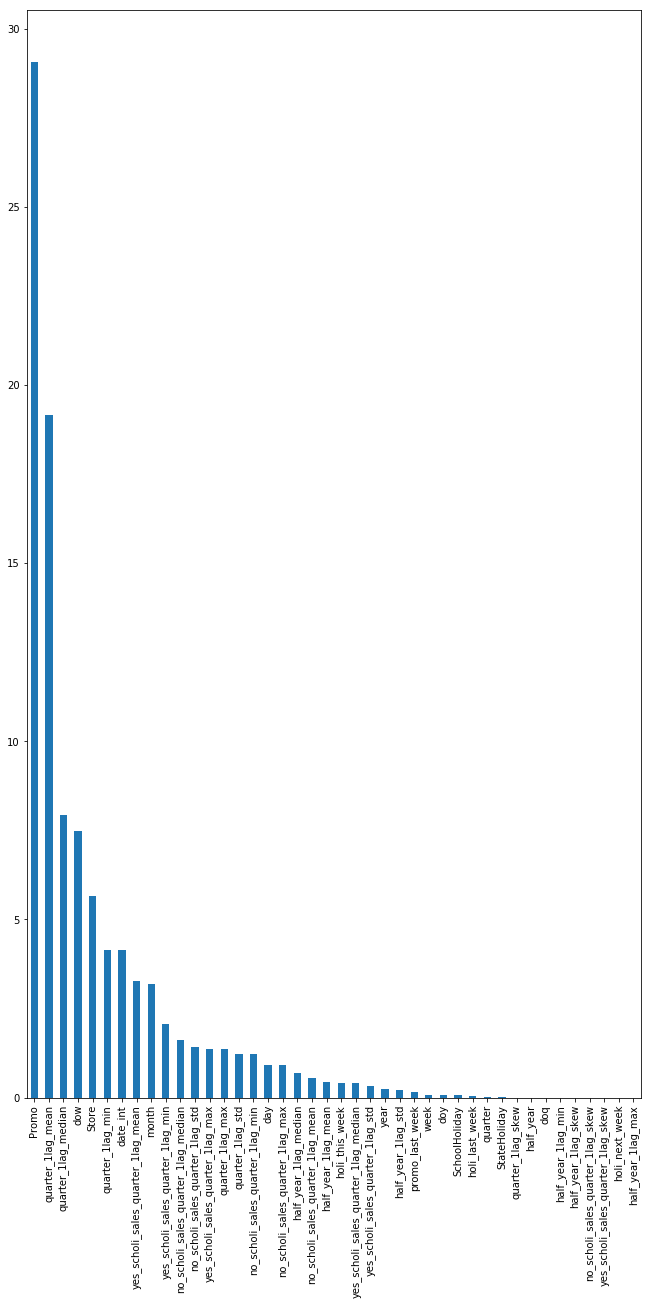

In [180]:
cat_test(data=data_with_date.drop(weak_col,axis=1).copy())

In [181]:
weak_col = sth_col+promo_notice[:2]+promo_prog
cat_test(data=data_with_date.drop(weak_col,axis=1).copy())

NameError: name 'sth_col' is not defined

In [ ]:
weak_col = sth_col+promo_notice+promo_prog+yesno_scholi+holi_notice
cat_test(data=data_with_date.drop(weak_col,axis=1).copy())

## sales in promo

In [182]:
quarterly_promo_sales = data_with_date.groupby([
    'Store','year','quarter','Promo'
],as_index=False)['Sales'].agg({
    'promo_sales_quarter_1lag_{}'.format(stats_col[0]):stats_col[0],
    'promo_sales_quarter_1lag_{}'.format(stats_col[1]):stats_col[1],
    'promo_sales_quarter_1lag_{}'.format(stats_col[2]):stats_col[2],
    'promo_sales_quarter_1lag_{}'.format(stats_col[3]):stats_col[3],
    'promo_sales_quarter_1lag_{}'.format(stats_col[4]):stats_col[4],
    'promo_sales_quarter_1lag_{}'.format(stats_col[5]):stats_col[5],
})

In [183]:
quarterly_promo_sales.head()

Store  year  quarter  Promo  promo_sales_quarter_1lag_max  \
0      1  2013        1      0                        7132.0   
1      1  2013        1      1                        7675.0   
2      1  2013        2      0                        5912.0   
3      1  2013        2      1                        7893.0   
4      1  2013        3      0                        5317.0   

   promo_sales_quarter_1lag_min  promo_sales_quarter_1lag_mean  \
0                        3725.0                    4794.317073   
1                        4881.0                    5950.117647   
2                        2952.0                    4434.575000   
3                        3939.0                    5220.060606   
4                        3096.0                    3974.227273   

   promo_sales_quarter_1lag_median  promo_sales_quarter_1lag_skew  \
0                           4709.0                       0.859877   
1                           5670.5                       0.657645   
2                           4370.0                       0.313930   
3                           5083.0                       1.163238   
4                           3958.5                       0.559991   

   promo_sales_quarter_1lag_std  
0                    736.447297  
1                    738.675381  
2                    720.974479  
3                    788.300503  
4                    429.814447

In [184]:
yes_quarterly_promo_sales = quarterly_promo_sales[
    quarterly_promo_sales.Promo==1
]
no_quarterly_promo_sales = quarterly_promo_sales[
    quarterly_promo_sales.Promo==0
]

In [185]:
yes_quarterly_promo_sales.shape,no_quarterly_promo_sales.shape

((11896, 10), (11896, 10))

In [186]:
yes_quarterly_promo_sales.sort_values(['Store',
                                       'year','quarter'],inplace=True)
no_quarterly_promo_sales.sort_values(['Store',
                                       'year','quarter'],inplace=True)

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [187]:
yes_quarterly_promo_sales.head()

Store  year  quarter  Promo  promo_sales_quarter_1lag_max  \
1      1  2013        1      1                        7675.0   
3      1  2013        2      1                        7893.0   
5      1  2013        3      1                        6377.0   
7      1  2013        4      1                        8414.0   
9      1  2014        1      1                        6198.0   

   promo_sales_quarter_1lag_min  promo_sales_quarter_1lag_mean  \
1                        4881.0                    5950.117647   
3                        3939.0                    5220.060606   
5                        4212.0                    5152.942857   
7                        4044.0                    5734.966667   
9                        4023.0                    5094.419355   

   promo_sales_quarter_1lag_median  promo_sales_quarter_1lag_skew  \
1                           5670.5                       0.657645   
3                           5083.0                       1.163238   
5                           5103.0                       0.253786   
7                           5512.0                       0.918545   
9                           5031.0                       0.245009   

   promo_sales_quarter_1lag_std  
1                    738.675381  
3                    788.300503  
5                    573.810429  
7                   1129.905290  
9                    609.053406

In [188]:
yes_quarterly_promo_sales.columns.tolist()

['Store',
 'year',
 'quarter',
 'Promo',
 'promo_sales_quarter_1lag_max',
 'promo_sales_quarter_1lag_min',
 'promo_sales_quarter_1lag_mean',
 'promo_sales_quarter_1lag_median',
 'promo_sales_quarter_1lag_skew',
 'promo_sales_quarter_1lag_std']

In [189]:
for col in yes_quarterly_promo_sales.columns.tolist():
    if col=='Store':
        yes_quarterly_promo_sales[
            'Store_Shifted']=yes_quarterly_promo_sales.Store.shift(1)
    elif col in ['year','quarter','Promo']:
        continue
    else:
        yes_quarterly_promo_sales['yes_'+col
                                 ]=yes_quarterly_promo_sales[col].shift(1)
        yes_quarterly_promo_sales.drop(col,axis=1,inplace=True)

for col in no_quarterly_promo_sales.columns.tolist():
    if col=='Store':
        no_quarterly_promo_sales[
            'Store_Shifted']=no_quarterly_promo_sales.Store.shift(1)
    elif col in ['year','quarter','Promo']:
        continue
    else:
        no_quarterly_promo_sales['no_'+col
                                 ]=no_quarterly_promo_sales[col].shift(1)
        no_quarterly_promo_sales.drop(col,axis=1,inplace=True)

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [190]:
yes_quarterly_promo_sales.head()

Store  year  quarter  Promo  Store_Shifted  \
1      1  2013        1      1            NaN   
3      1  2013        2      1            1.0   
5      1  2013        3      1            1.0   
7      1  2013        4      1            1.0   
9      1  2014        1      1            1.0   

   yes_promo_sales_quarter_1lag_max  yes_promo_sales_quarter_1lag_min  \
1                               NaN                               NaN   
3                            7675.0                            4881.0   
5                            7893.0                            3939.0   
7                            6377.0                            4212.0   
9                            8414.0                            4044.0   

   yes_promo_sales_quarter_1lag_mean  yes_promo_sales_quarter_1lag_median  \
1                                NaN                                  NaN   
3                        5950.117647                               5670.5   
5                        5220.060606                               5083.0   
7                        5152.942857                               5103.0   
9                        5734.966667                               5512.0   

   yes_promo_sales_quarter_1lag_skew  yes_promo_sales_quarter_1lag_std  
1                                NaN                               NaN  
3                           0.657645                        738.675381  
5                           1.163238                        788.300503  
7                           0.253786                        573.810429  
9                           0.918545                       1129.905290

In [191]:
def get_zeros(data):
    if data.Store!=data.Store_Shifted:
        for col in data.index.tolist():
            if col not in ['Store','year','quarter','Promo',
                           'Store_Shifted']:
                data[col]=0
    data.drop(['Promo','Store_Shifted'],inplace=True)
    return data

In [192]:
yes_quarterly_promo_sales=yes_quarterly_promo_sales.apply(get_zeros,axis=1)
no_quarterly_promo_sales=no_quarterly_promo_sales.apply(get_zeros,axis=1)

In [193]:
no_quarterly_promo_sales.head()

Store    year  quarter  no_promo_sales_quarter_1lag_max  \
0    1.0  2013.0      1.0                              0.0   
2    1.0  2013.0      2.0                           7132.0   
4    1.0  2013.0      3.0                           5912.0   
6    1.0  2013.0      4.0                           5317.0   
8    1.0  2014.0      1.0                           9528.0   

   no_promo_sales_quarter_1lag_min  no_promo_sales_quarter_1lag_mean  \
0                              0.0                          0.000000   
2                           3725.0                       4794.317073   
4                           2952.0                       4434.575000   
6                           3096.0                       3974.227273   
8                           2362.0                       4681.652174   

   no_promo_sales_quarter_1lag_median  no_promo_sales_quarter_1lag_skew  \
0                                 0.0                          0.000000   
2                              4709.0                          0.859877   
4                              4370.0                          0.313930   
6                              3958.5                          0.559991   
8                              4324.0                          1.495479   

   no_promo_sales_quarter_1lag_std  
0                         0.000000  
2                       736.447297  
4                       720.974479  
6                       429.814447  
8                      1322.444205

In [194]:
yes_quarterly_promo_sales.head()

Store    year  quarter  yes_promo_sales_quarter_1lag_max  \
1    1.0  2013.0      1.0                               0.0   
3    1.0  2013.0      2.0                            7675.0   
5    1.0  2013.0      3.0                            7893.0   
7    1.0  2013.0      4.0                            6377.0   
9    1.0  2014.0      1.0                            8414.0   

   yes_promo_sales_quarter_1lag_min  yes_promo_sales_quarter_1lag_mean  \
1                               0.0                           0.000000   
3                            4881.0                        5950.117647   
5                            3939.0                        5220.060606   
7                            4212.0                        5152.942857   
9                            4044.0                        5734.966667   

   yes_promo_sales_quarter_1lag_median  yes_promo_sales_quarter_1lag_skew  \
1                                  0.0                           0.000000   
3                               5670.5                           0.657645   
5                               5083.0                           1.163238   
7                               5103.0                           0.253786   
9                               5512.0                           0.918545   

   yes_promo_sales_quarter_1lag_std  
1                          0.000000  
3                        738.675381  
5                        788.300503  
7                        573.810429  
9                       1129.905290

In [195]:
eng_feat['yesno_promo']=[
    'yes_promo_sales_quarter_1lag_{}'.format(i) for i in stats_col
]+['no_promo_sales_quarter_1lag_{}'.format(i) for i in stats_col]

In [196]:
data_with_date = data_with_date.merge(yes_quarterly_promo_sales,how='left',
                    on=['Store','year','quarter'])

In [197]:
data_with_date = data_with_date.merge(no_quarterly_promo_sales,how='left',
                                     on=['Store','year','quarter'])

In [198]:
data_with_date.head()

Date  DayOfWeek   Id  Open  Promo   Sales  SchoolHoliday  \
0  2015-07-31          5  0.0   1.0      1  5263.0              1   
1  2015-07-30          4  0.0   1.0      1  5020.0              1   
2  2015-07-29          3  0.0   1.0      1  4782.0              1   
3  2015-07-28          2  0.0   1.0      1  5011.0              1   
4  2015-07-27          1  0.0   1.0      1  6102.0              1   

  StateHoliday Store  year               ...                 \
0            0     1  2015               ...                  
1            0     1  2015               ...                  
2            0     1  2015               ...                  
3            0     1  2015               ...                  
4            0     1  2015               ...                  

   yes_promo_sales_quarter_1lag_mean  yes_promo_sales_quarter_1lag_median  \
0                         5109.15625                               5198.0   
1                         5109.15625                               5198.0   
2                         5109.15625                               5198.0   
3                         5109.15625                               5198.0   
4                         5109.15625                               5198.0   

   yes_promo_sales_quarter_1lag_skew yes_promo_sales_quarter_1lag_std  \
0                           0.294039                       739.168326   
1                           0.294039                       739.168326   
2                           0.294039                       739.168326   
3                           0.294039                       739.168326   
4                           0.294039                       739.168326   

   no_promo_sales_quarter_1lag_max no_promo_sales_quarter_1lag_min  \
0                           6709.0                          3037.0   
1                           6709.0                          3037.0   
2                           6709.0                          3037.0   
3                           6709.0                          3037.0   
4                           6709.0                          3037.0   

   no_promo_sales_quarter_1lag_mean  no_promo_sales_quarter_1lag_median  \
0                          4059.825                              4077.0   
1                          4059.825                              4077.0   
2                          4059.825                              4077.0   
3                          4059.825                              4077.0   
4                          4059.825                              4077.0   

  no_promo_sales_quarter_1lag_skew  no_promo_sales_quarter_1lag_std  
0                         1.656591                       733.053288  
1                         1.656591                       733.053288  
2                         1.656591                       733.053288  
3                         1.656591                       733.053288  
4                         1.656591                       733.053288  

[5 rows x 87 columns]

rmspe is 0.1522


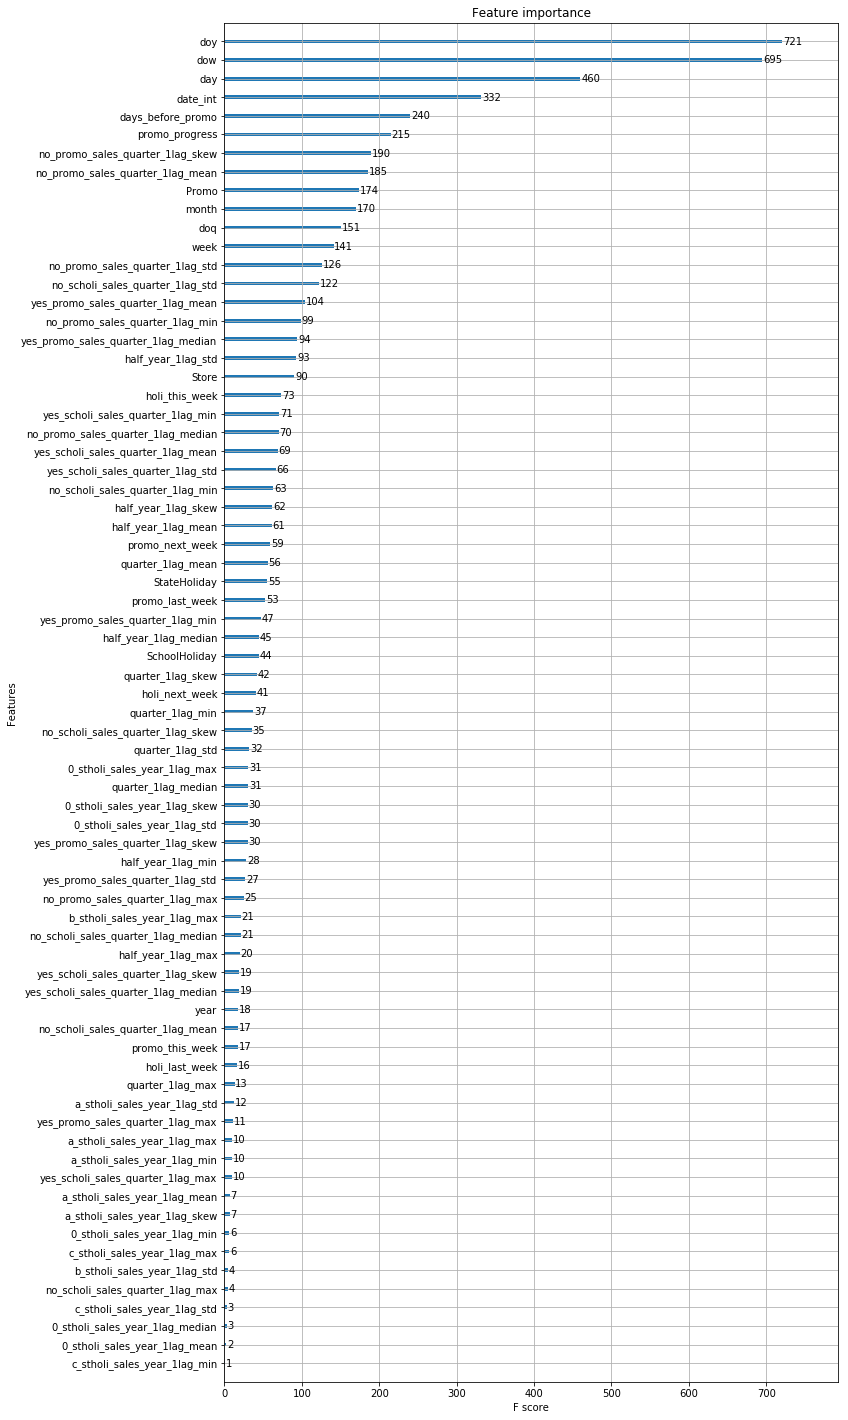

In [199]:
xgb_test(data=data_with_date.copy(),eta=0.06,hight=25)

rmspe is 0.1655


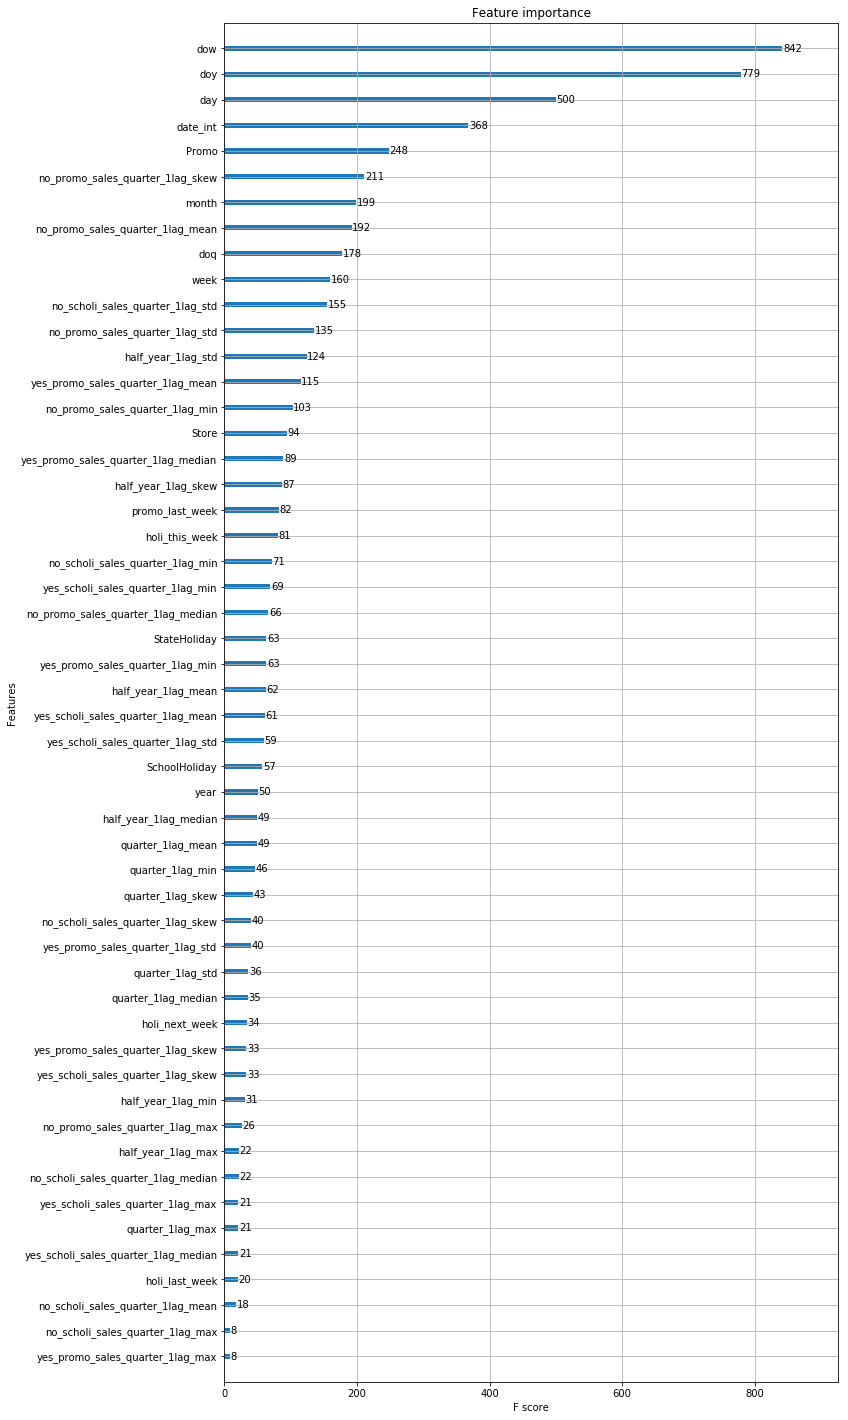

In [200]:
weak_col = eng_feat['sth_col']+eng_feat['promo_notice'][:2]+\
            eng_feat['promo_prog']
xgb_test(data=data_with_date.drop(weak_col,axis=1),
        hight=25,eta=0.06)

rmspe is 0.1497


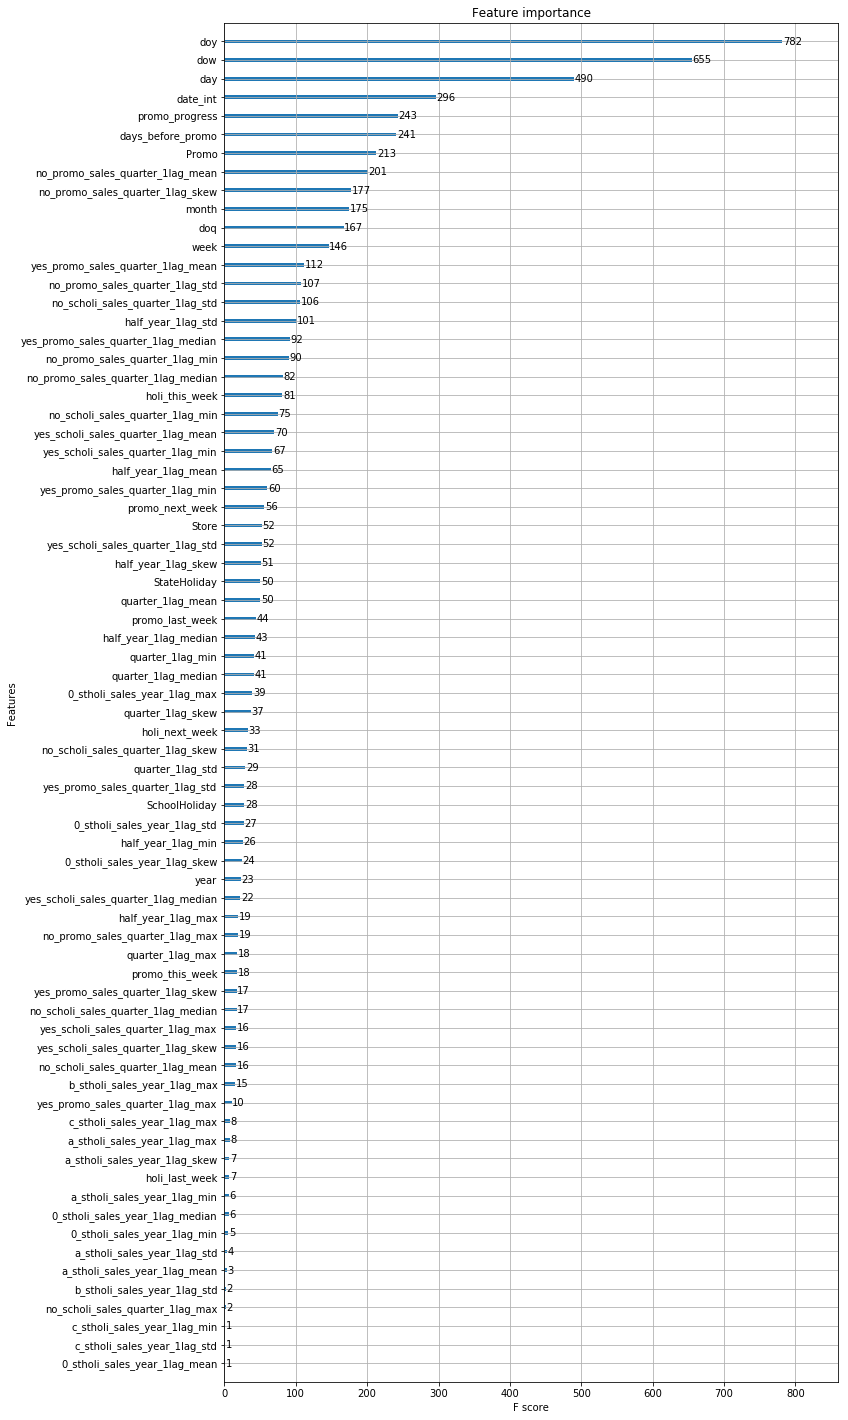

In [201]:
xgb_test(data=data_with_date.copy(),eta=0.05,hight=25)

## weekend sales

In [202]:
for_weekend = data_with_date[['Store','year','quarter','dow','Sales']]

In [203]:
for_weekend.head()

Store  year quarter  dow   Sales
0     1  2015       3    4  5263.0
1     1  2015       3    3  5020.0
2     1  2015       3    2  4782.0
3     1  2015       3    1  5011.0
4     1  2015       3    0  6102.0

In [204]:
for_weekend.dow.unique()

array([4, 3, 2, 1, 0, 5, 6], dtype=int64)

In [205]:
data_with_date.iloc[:7,:15]

Date  DayOfWeek       Id  Open  Promo   Sales  SchoolHoliday  \
0  2015-07-31          5      0.0   1.0      1  5263.0              1   
1  2015-07-30          4      0.0   1.0      1  5020.0              1   
2  2015-07-29          3      0.0   1.0      1  4782.0              1   
3  2015-07-28          2      0.0   1.0      1  5011.0              1   
4  2015-07-27          1      0.0   1.0      1  6102.0              1   
5  2015-08-01          6  40233.0   1.0      0     0.0              1   
6  2015-07-31          5      0.0   1.0      1  6064.0              1   

  StateHoliday Store  year  month  dow  doy quarter  day  
0            0     1  2015      7    4  212       3   31  
1            0     1  2015      7    3  211       3   30  
2            0     1  2015      7    2  210       3   29  
3            0     1  2015      7    1  209       3   28  
4            0     1  2015      7    0  208       3   27  
5            0     1  2015      8    5  213       3    1  
6            0     2  2015      7    4  212       3   31

In [206]:
for_weekend.dow.unique()[for_weekend.dow.unique()>4]

array([5, 6], dtype=int64)

In [207]:
for_weekend['weekend'] = for_weekend.dow.apply(lambda x:1 if x>4 else 0)

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [208]:
for_weekend.head(10)

Store  year quarter  dow   Sales  weekend
0     1  2015       3    4  5263.0        0
1     1  2015       3    3  5020.0        0
2     1  2015       3    2  4782.0        0
3     1  2015       3    1  5011.0        0
4     1  2015       3    0  6102.0        0
5     1  2015       3    5     0.0        1
6     2  2015       3    4  6064.0        0
7     2  2015       3    3  5567.0        0
8     2  2015       3    2  6402.0        0
9     2  2015       3    1  5671.0        0

In [209]:
yes_for_weekend = for_weekend[for_weekend.weekend==1]
no_for_weekend = for_weekend[for_weekend.weekend==0]

In [210]:
yes_for_weekend.reset_index(drop=True,inplace=True)
no_for_weekend.reset_index(drop=True,inplace=True)

In [211]:
yes_for_weekend.shape,no_for_weekend.shape

((153643, 6), (725715, 6))

In [212]:
yes_for_weekend.head()

Store  year quarter  dow  Sales  weekend
0     1  2015       3    5    0.0        1
1     3  2015       3    5    0.0        1
2     7  2015       3    5    0.0        1
3     8  2015       3    5    0.0        1
4     9  2015       3    5    0.0        1

In [213]:
yes_for_weekend_in_quarter = yes_for_weekend.groupby(
    ['Store','year','quarter']
,as_index=False)['Sales'].agg({
    'yes_for_weekend_in_quarter_{}'.format(i):i for i in stats_col
}
)
no_for_weekend_in_quarter = no_for_weekend.groupby(
    ['Store','year','quarter']
,as_index=False)['Sales'].agg({
    'no_for_weekend_in_quarter_{}'.format(i):i for i in stats_col
})

In [214]:
yes_for_weekend_in_quarter.head()

Store  year  quarter  yes_for_weekend_in_quarter_max  \
0      1  2013        1                          7132.0   
1      1  2013        2                          5912.0   
2      1  2013        3                          5317.0   
3      1  2013        4                          8043.0   
4      1  2014        1                          5307.0   

   yes_for_weekend_in_quarter_min  yes_for_weekend_in_quarter_mean  \
0                          4952.0                      5548.153846   
1                          4262.0                      4968.230769   
2                          3352.0                      4281.846154   
3                          3667.0                      5430.384615   
4                          4400.0                      4920.769231   

   yes_for_weekend_in_quarter_median  yes_for_weekend_in_quarter_skew  \
0                             5370.0                         1.659310   
1                             4773.0                         0.421637   
2                             4175.0                         0.232985   
3                             5297.0                         0.952285   
4                             5042.0                        -0.329918   

   yes_for_weekend_in_quarter_std  
0                      599.875521  
1                      624.821862  
2                      505.243480  
3                     1066.162788  
4                      343.538487

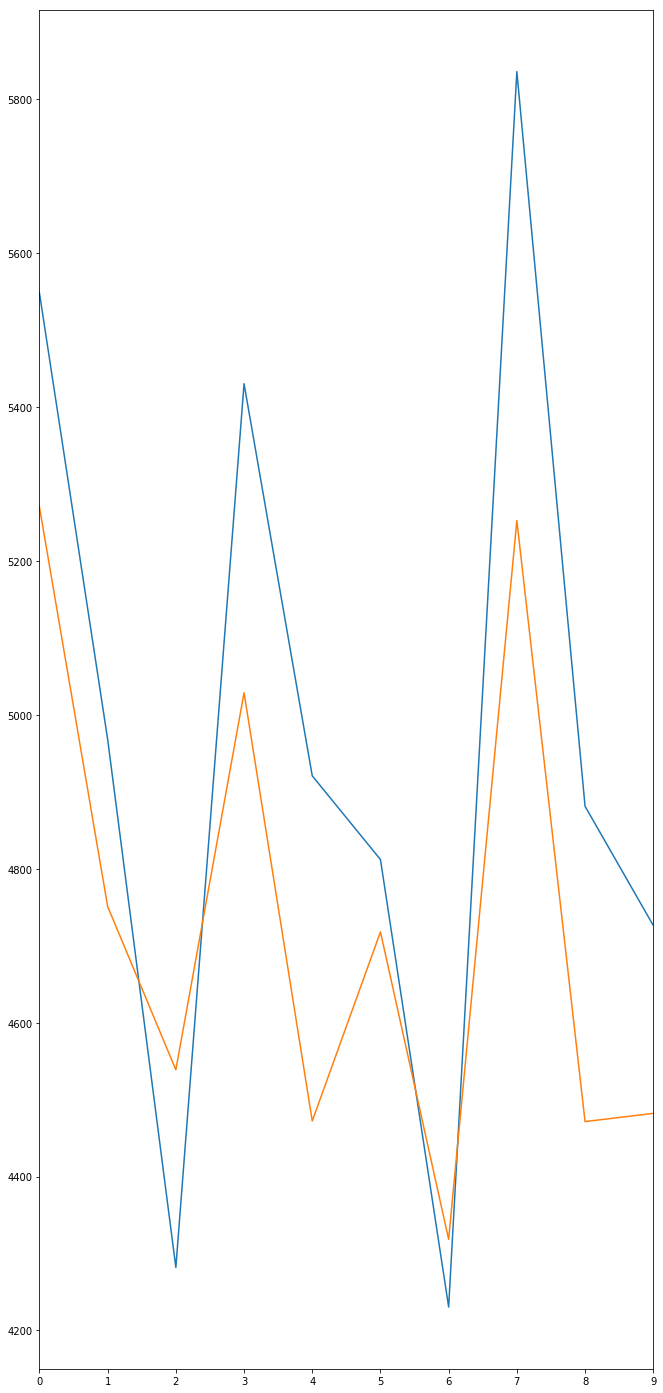

In [215]:
yes_for_weekend_in_quarter[yes_for_weekend_in_quarter.Store==1
                          ].yes_for_weekend_in_quarter_mean.iloc[:-1].plot();
no_for_weekend_in_quarter[no_for_weekend_in_quarter.Store==1
                         ].no_for_weekend_in_quarter_mean.iloc[:-1].plot();

C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Xufeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series 

"\nfor_weekend[for_weekend.dow==6][for_weekend.Store==1].groupby(\n    ['Store','year','quarter'],\nas_index=False)['Sales'].mean().Sales.iloc[:-1].plot();\n"

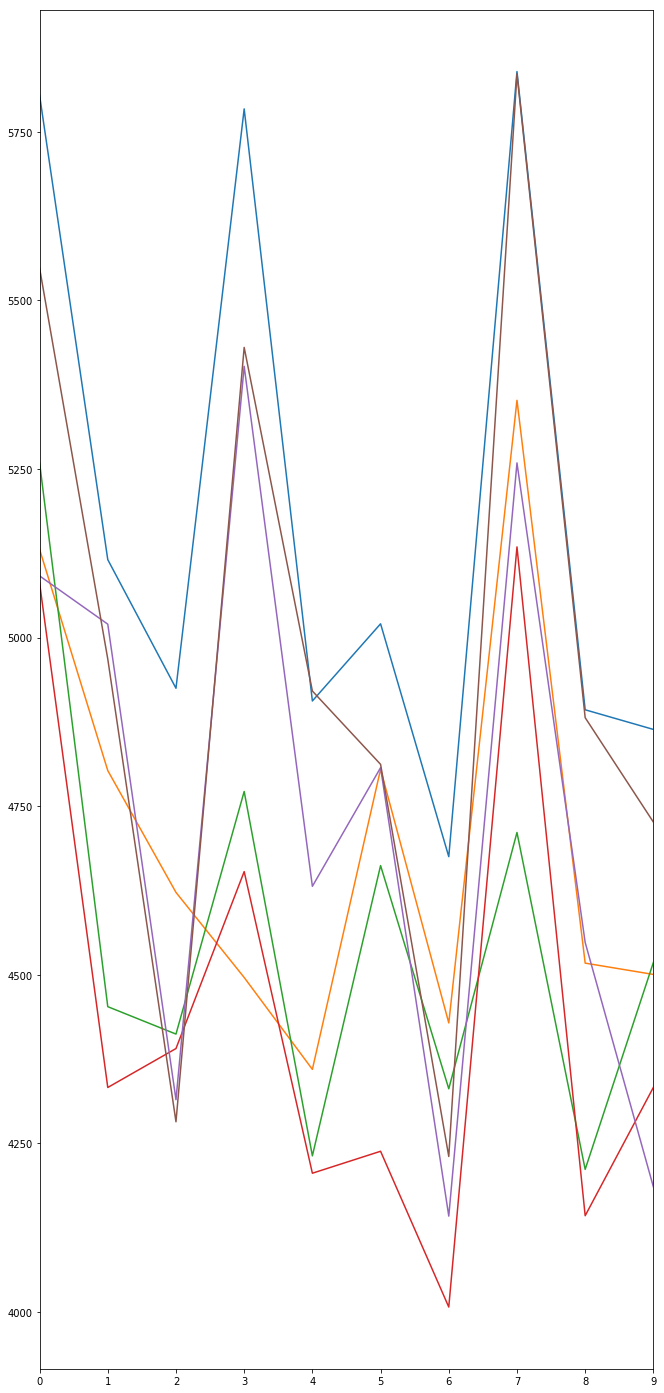

In [216]:
for_weekend[for_weekend.dow==0][for_weekend.Store==1].groupby(
    ['Store','year','quarter'],
as_index=False)['Sales'].mean().Sales.iloc[:-1].plot();
for_weekend[for_weekend.dow==1][for_weekend.Store==1].groupby(
    ['Store','year','quarter'],
as_index=False)['Sales'].mean().Sales.iloc[:-1].plot();
for_weekend[for_weekend.dow==2][for_weekend.Store==1].groupby(
    ['Store','year','quarter'],
as_index=False)['Sales'].mean().Sales.iloc[:-1].plot();
for_weekend[for_weekend.dow==3][for_weekend.Store==1].groupby(
    ['Store','year','quarter'],
as_index=False)['Sales'].mean().Sales.iloc[:-1].plot();
for_weekend[for_weekend.dow==4][for_weekend.Store==1].groupby(
    ['Store','year','quarter'],
as_index=False)['Sales'].mean().Sales.iloc[:-1].plot();

for_weekend[for_weekend.dow==5][for_weekend.Store==1].groupby(
    ['Store','year','quarter'],
as_index=False)['Sales'].mean().Sales.iloc[:-1].plot();
'''
for_weekend[for_weekend.dow==6][for_weekend.Store==1].groupby(
    ['Store','year','quarter'],
as_index=False)['Sales'].mean().Sales.iloc[:-1].plot();
'''

### there are some stores that doesn't open on Sunday, fill null values

In [217]:
for_weekend.dow.unique()

array([4, 3, 2, 1, 0, 5, 6], dtype=int64)

In [218]:
monday_quarter_sales = for_weekend[for_weekend.dow==0].groupby([
    'Store','year','quarter'
],as_index=False)['Sales'].agg({
    'monday_quarter_1lag_{}'.format(i):i for i in stats_col
}).sort_values(by=['Store','year','quarter'])
tuesday_quarter_sales = for_weekend[for_weekend.dow==1].groupby([
    'Store','year','quarter'
],as_index=False)['Sales'].agg({
    'tuesday_quarter_1lag_{}'.format(i):i for i in stats_col
}).sort_values(by=['Store','year','quarter'])
wednesday_quarter_sales = for_weekend[for_weekend.dow==2].groupby([
    'Store','year','quarter'
],as_index=False)['Sales'].agg({
    'wednesday_quarter_1lag_{}'.format(i):i for i in stats_col
}).sort_values(by=['Store','year','quarter'])
thursday_quarter_sales = for_weekend[for_weekend.dow==3].groupby([
    'Store','year','quarter'
],as_index=False)['Sales'].agg({
    'thursday_quarter_1lag_{}'.format(i):i for i in stats_col
}).sort_values(by=['Store','year','quarter'])
friday_quarter_sales = for_weekend[for_weekend.dow==4].groupby([
    'Store','year','quarter'
],as_index=False)['Sales'].agg({
    'friday_quarter_1lag_{}'.format(i):i for i in stats_col
}).sort_values(by=['Store','year','quarter'])
saturday_quarter_sales = for_weekend[for_weekend.dow==5].groupby([
    'Store','year','quarter'
],as_index=False)['Sales'].agg({
    'saturday_quarter_1lag_{}'.format(i):i for i in stats_col
}).sort_values(by=['Store','year','quarter'])
sunday_quarter_sales = for_weekend[for_weekend.dow==6].groupby([
    'Store','year','quarter'
],as_index=False)['Sales'].agg({
    'sunday_quarter_1lag_{}'.format(i):i for i in stats_col
}).sort_values(by=['Store','year','quarter'])

In [219]:
sunday_quarter_sales.head()

Store  year  quarter  sunday_quarter_1lag_max  sunday_quarter_1lag_min  \
0     85  2013        1                  13302.0                   7522.0   
1     85  2013        2                  14016.0                   7796.0   
2     85  2013        3                  14538.0                   7317.0   
3     85  2013        4                  13629.0                   7310.0   
4     85  2014        1                  12576.0                   7303.0   

   sunday_quarter_1lag_mean  sunday_quarter_1lag_median  \
0              11092.923077                     11390.0   
1              11770.461538                     11625.0   
2              11630.769231                     11884.0   
3              10929.230769                     11525.0   
4              10803.769231                     11254.0   

   sunday_quarter_1lag_skew  sunday_quarter_1lag_std  
0                 -0.671054              1655.480719  
1                 -0.607614              1795.202199  
2                 -0.892389              2019.158742  
3                 -0.374712              2428.688746  
4                 -1.509721              1641.096237

In [220]:
def do_lag(data):
    data['Store_Shifted']=data.Store.shift(1)
    for col in data.columns.tolist():
        if col in ['Store','year','quarter','Store_Shifted']:
            continue
        else:
            data[col]=data[col].shift(1)
    def get_zero(data):
        if data.Store!=data.Store_Shifted:
            for idx in data.index.tolist():
                if idx not in ['Store','year','quarter','Store_Shifted']:
                    data[idx]=0
        return data
    data = data.apply(get_zero,axis=1)
    data.drop('Store_Shifted',axis=1,inplace=True)
    return data

In [221]:
monday_quarter_sales = do_lag(monday_quarter_sales)
tuesday_quarter_sales = do_lag(tuesday_quarter_sales)
wednesday_quarter_sales = do_lag(wednesday_quarter_sales)
thursday_quarter_sales = do_lag(thursday_quarter_sales)
friday_quarter_sales = do_lag(friday_quarter_sales)
saturday_quarter_sales = do_lag(saturday_quarter_sales)
sunday_quarter_sales = do_lag(sunday_quarter_sales)

In [222]:
monday_quarter_sales.head()

Store    year  quarter  monday_quarter_1lag_max  monday_quarter_1lag_min  \
0    1.0  2013.0      1.0                      0.0                      0.0   
1    1.0  2013.0      2.0                   7675.0                   4038.0   
2    1.0  2013.0      3.0                   6106.0                   3549.0   
3    1.0  2013.0      4.0                   6377.0                   3954.0   
4    1.0  2014.0      1.0                   9528.0                   3557.0   

   monday_quarter_1lag_mean  monday_quarter_1lag_median  \
0                  0.000000                         0.0   
1               5804.416667                      5900.5   
2               5115.636364                      5422.0   
3               4924.857143                      4622.5   
4               5784.153846                      5861.0   

   monday_quarter_1lag_skew  monday_quarter_1lag_std  
0                  0.000000                 0.000000  
1                 -0.069027              1345.786047  
2                 -0.675168               881.651209  
3                  0.494363               877.944790  
4                  0.714417              1813.225848

In [223]:
eng_feat['dow_quarter_1lag']=['{}_quarter_1lag_{}'.format(i,j) for i in ['monday','tuesday','wednesday',
                                           'thursday','friday','saturday',
                                           'sunday'] for j in stats_col]

In [224]:
data_with_date = data_with_date.merge(monday_quarter_sales,how='left',on=['Store','year','quarter'])
data_with_date = data_with_date.merge(tuesday_quarter_sales,how='left',on=['Store','year','quarter'])
data_with_date = data_with_date.merge(wednesday_quarter_sales,how='left',on=['Store','year','quarter'])
data_with_date = data_with_date.merge(thursday_quarter_sales,how='left',on=['Store','year','quarter'])
data_with_date = data_with_date.merge(friday_quarter_sales,how='left',on=['Store','year','quarter'])
data_with_date = data_with_date.merge(saturday_quarter_sales,how='left',on=['Store','year','quarter'])
data_with_date = data_with_date.merge(sunday_quarter_sales,how='left',on=['Store','year','quarter'])

In [225]:
data_with_date.shape

(879358, 129)

In [226]:
data_with_date.fillna(0,inplace=True)

rmspe is 0.1450


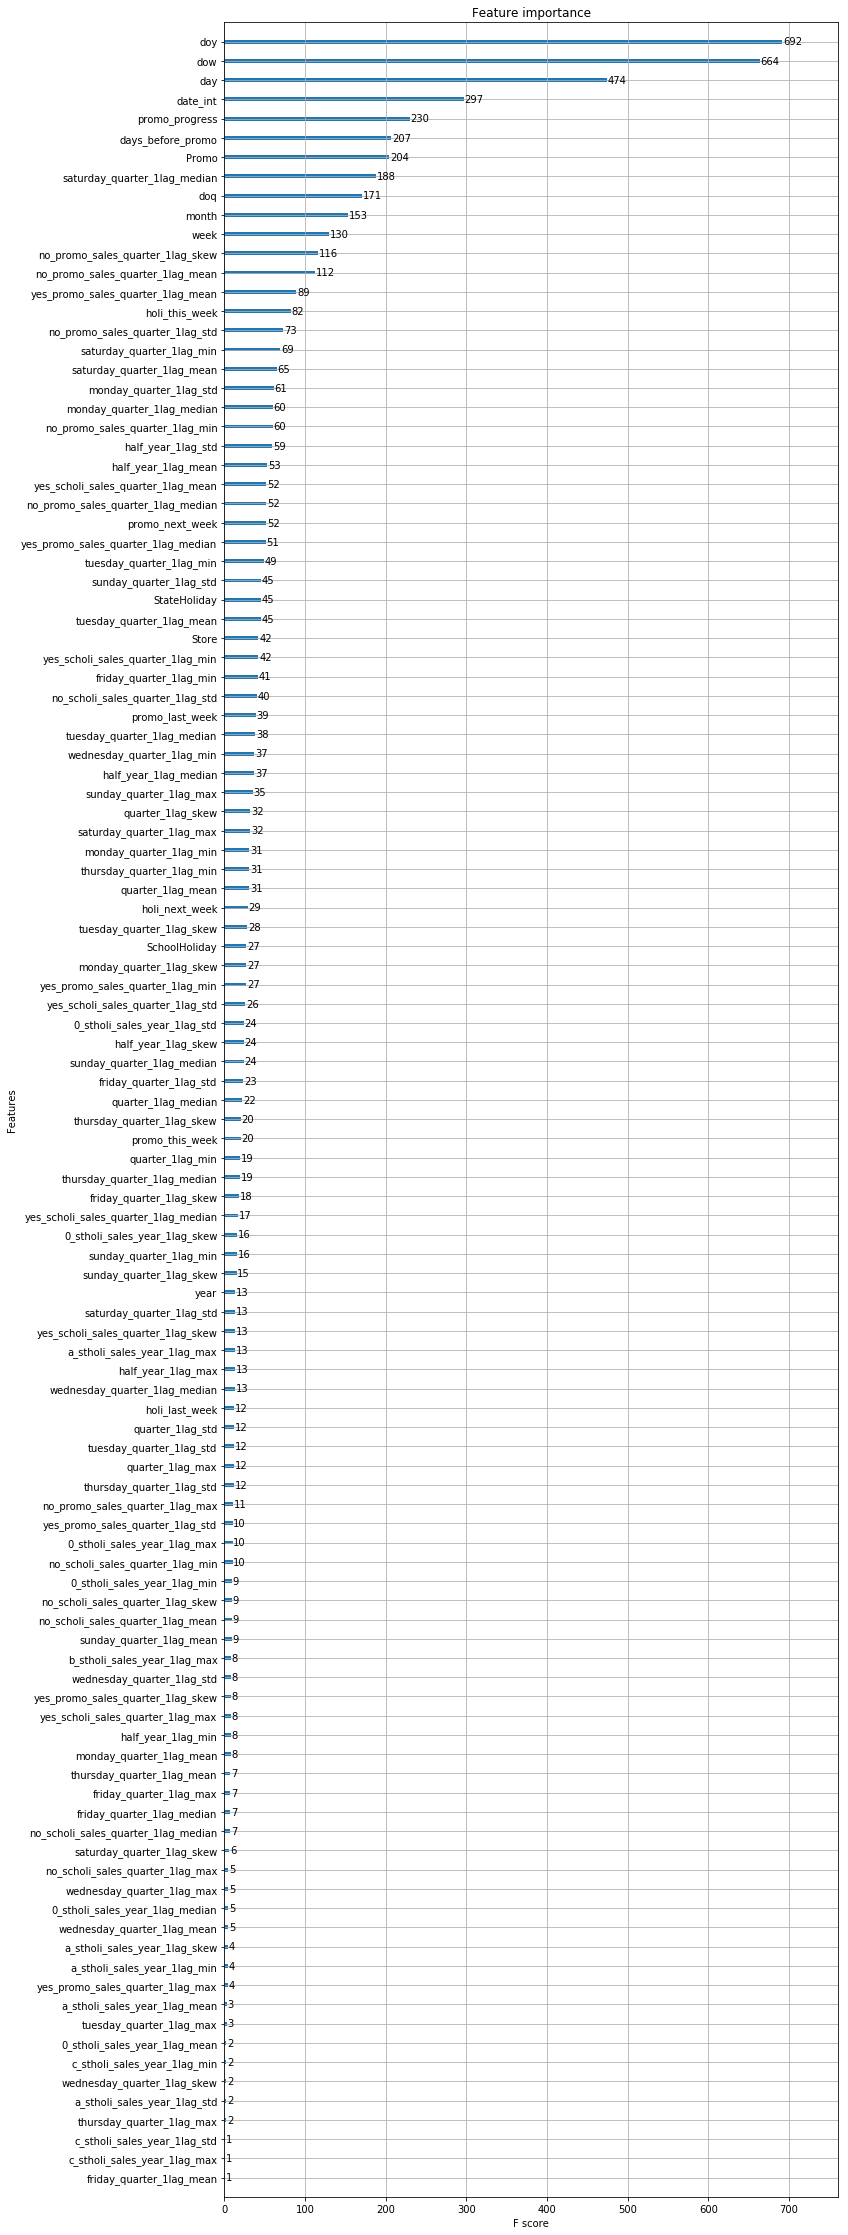

In [227]:
xgb_test(data_with_date.copy(),eta=0.05,hight=40)

rmspe is 0.1434


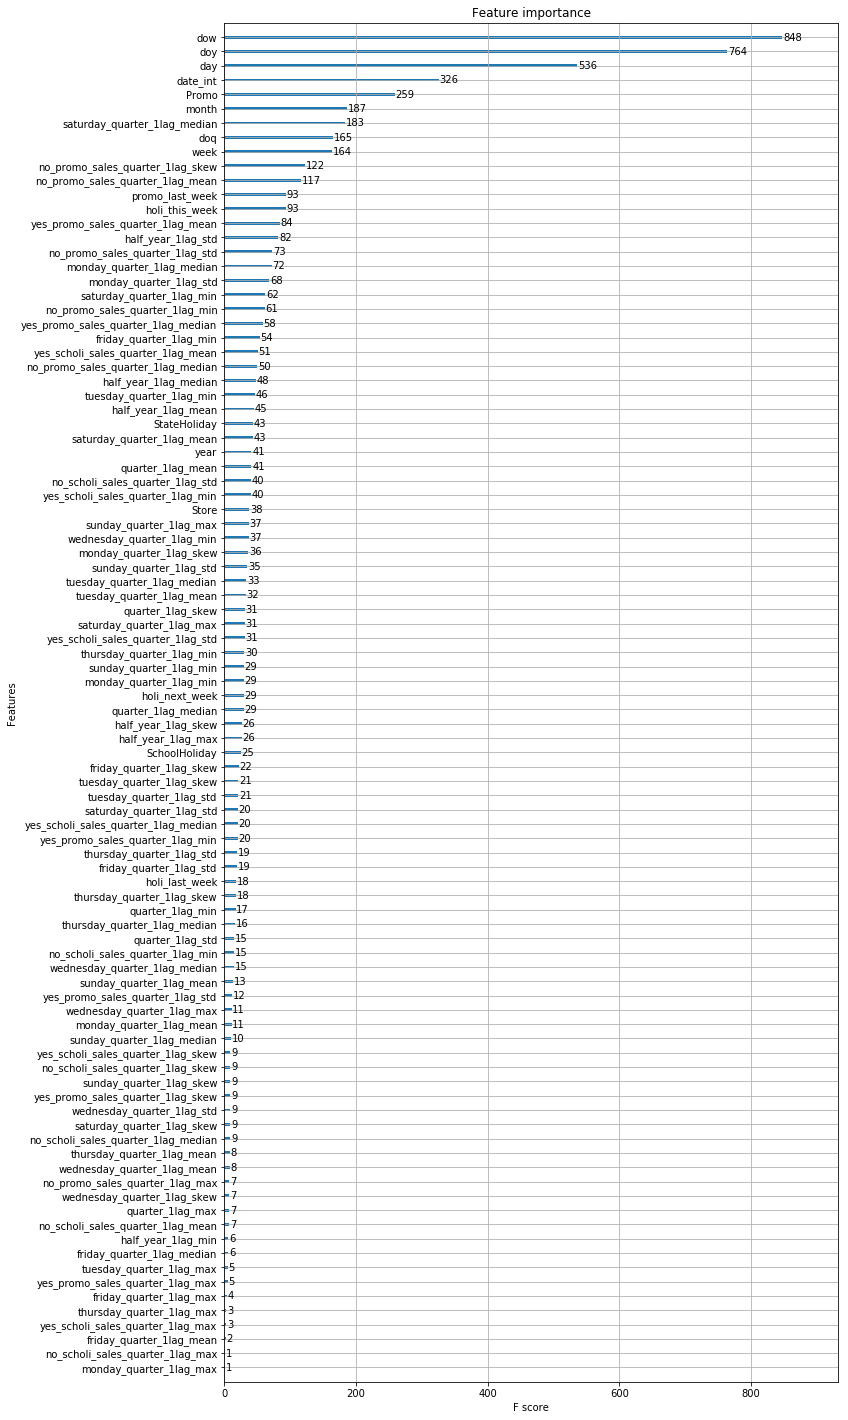

In [228]:
weak_col = eng_feat['sth_col']+eng_feat['promo_notice'][:2]+\
            eng_feat['promo_prog']
xgb_test(data=data_with_date.drop(weak_col,axis=1),
        hight=25,eta=0.045)

rmspe is 0.1658


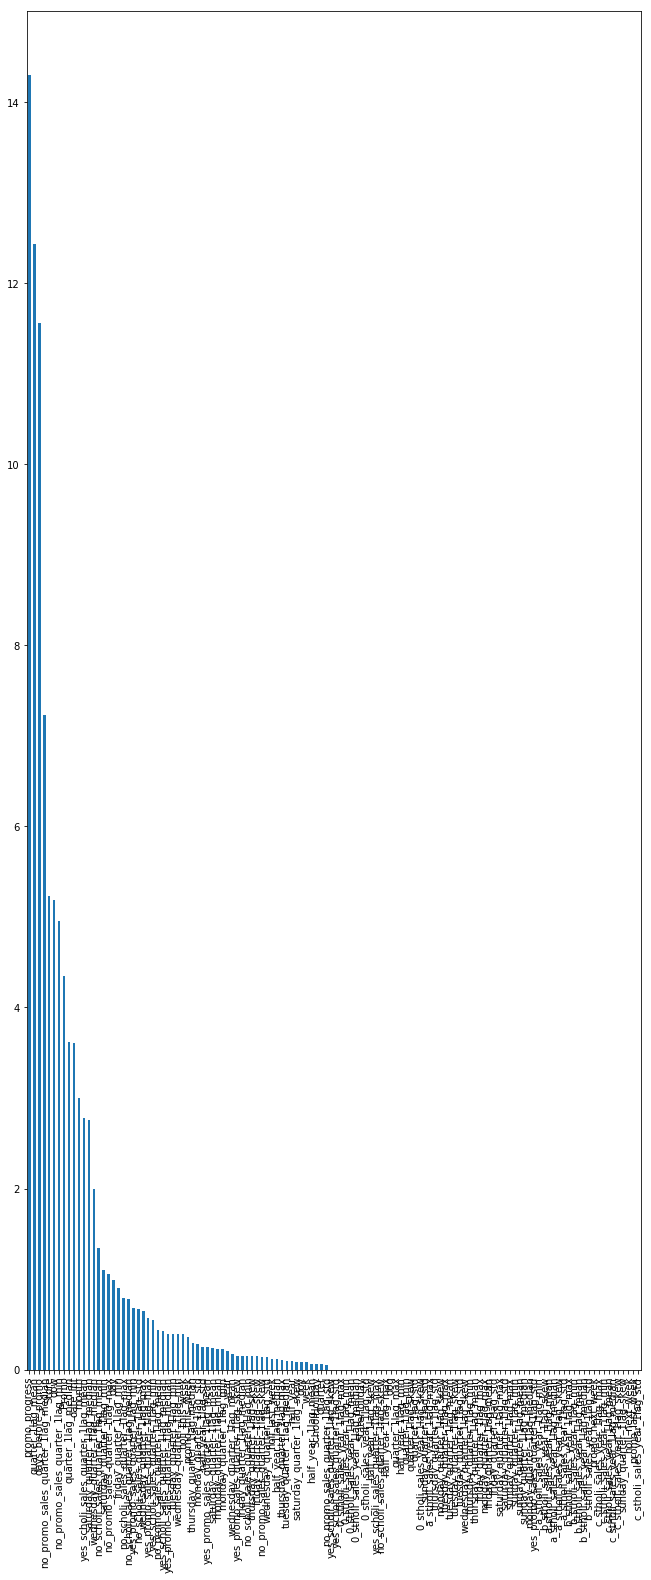

In [229]:
cat_test(data=data_with_date)

In [230]:
data_with_date.columns

Index(['Date', 'DayOfWeek', 'Id', 'Open', 'Promo', 'Sales', 'SchoolHoliday',
       'StateHoliday', 'Store', 'year',
       ...
       'saturday_quarter_1lag_mean', 'saturday_quarter_1lag_median',
       'saturday_quarter_1lag_skew', 'saturday_quarter_1lag_std',
       'sunday_quarter_1lag_max', 'sunday_quarter_1lag_min',
       'sunday_quarter_1lag_mean', 'sunday_quarter_1lag_median',
       'sunday_quarter_1lag_skew', 'sunday_quarter_1lag_std'],
      dtype='object', length=129)

In [231]:
data['store'].head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [232]:
str(data['store'].iloc[0].PromoInterval)

'nan'

In [233]:
store_info = data['store'][['Store','CompetitionDistance']].fillna(0)

In [234]:
data['store'].shape,store_info.shape

((1115, 10), (1115, 2))

In [235]:
store_info['StoreType']=lbl.fit_transform(data['store'].StoreType)
store_info['Assortment']=lbl.fit_transform(data['store'].Assortment)
store_info['CompetitionOpenSinceMonth']=data['store'].CompetitionOpenSinceMonth.fillna(0)
store_info['Promo2'] = data['store'].Promo2
store_info['Promo2SinceWeek'] = data['store'].Promo2SinceWeek.fillna(0)
store_info['PromoInterval'] = lbl.fit_transform(data['store'].PromoInterval.fillna('nan'))

In [236]:
store_info.head()

Store  CompetitionDistance  StoreType  Assortment  \
0      1               1270.0          2           0   
1      2                570.0          0           0   
2      3              14130.0          0           0   
3      4                620.0          2           2   
4      5              29910.0          0           0   

   CompetitionOpenSinceMonth  Promo2  Promo2SinceWeek  PromoInterval  
0                        9.0       0              0.0              3  
1                       11.0       1             13.0              1  
2                       12.0       1             14.0              1  
3                        9.0       0              0.0              3  
4                        4.0       0              0.0              3

In [237]:
data_with_date.Store.unique()

array([   1,    2,    3, ..., 1115,  876,  292], dtype=int64)

In [238]:
store_info.Store.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

In [239]:
data_with_date = data_with_date.merge(store_info,how='left',on='Store')

In [240]:
data_with_date.shape

(879358, 136)

rmspe is 0.1446


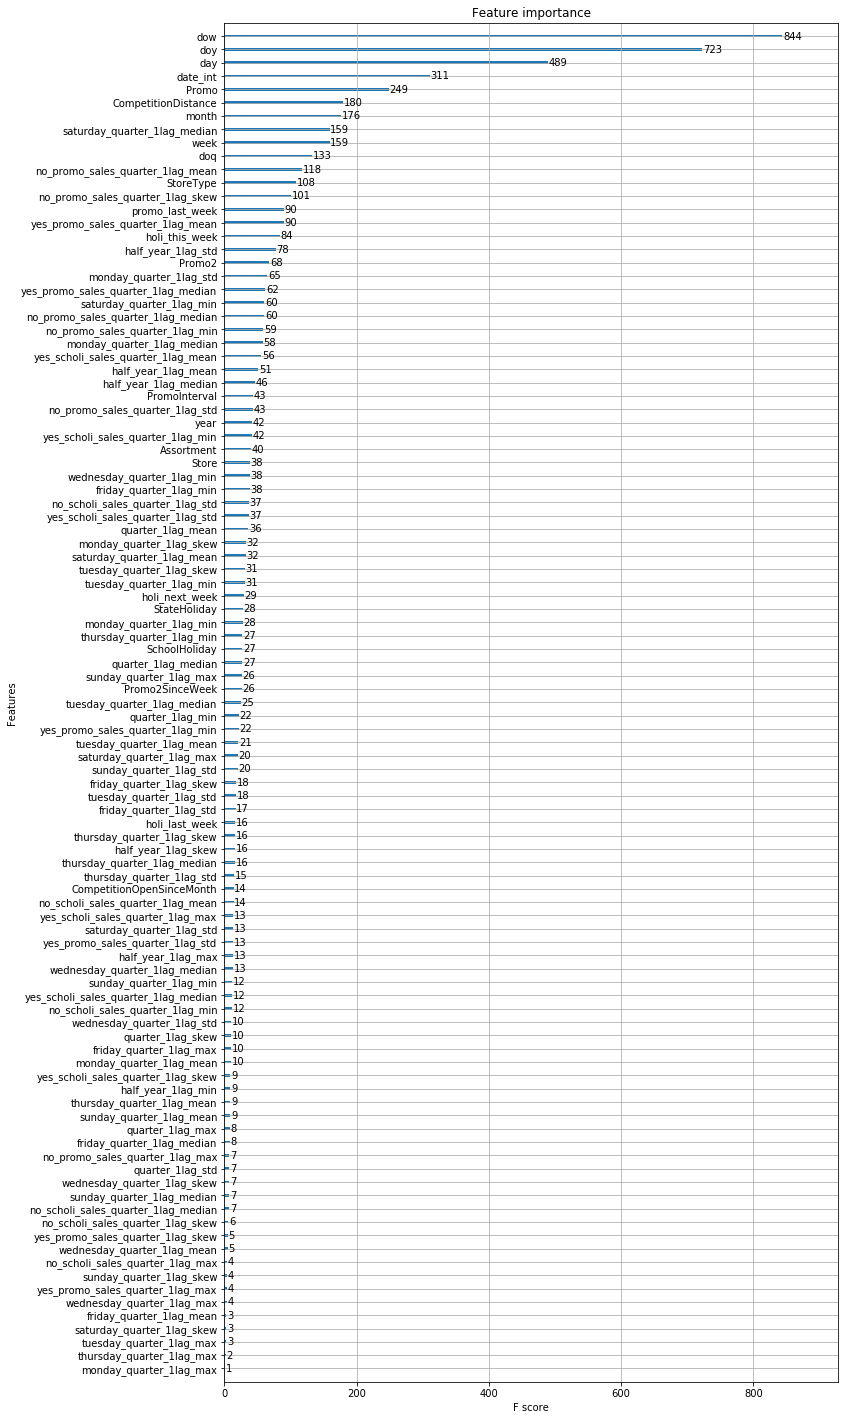

In [241]:
weak_col = eng_feat['sth_col']+eng_feat['promo_notice'][:2]+\
            eng_feat['promo_prog']
xgb_test(data=data_with_date.drop(weak_col,axis=1),
        hight=25,eta=0.045)

rmspe is 0.1466


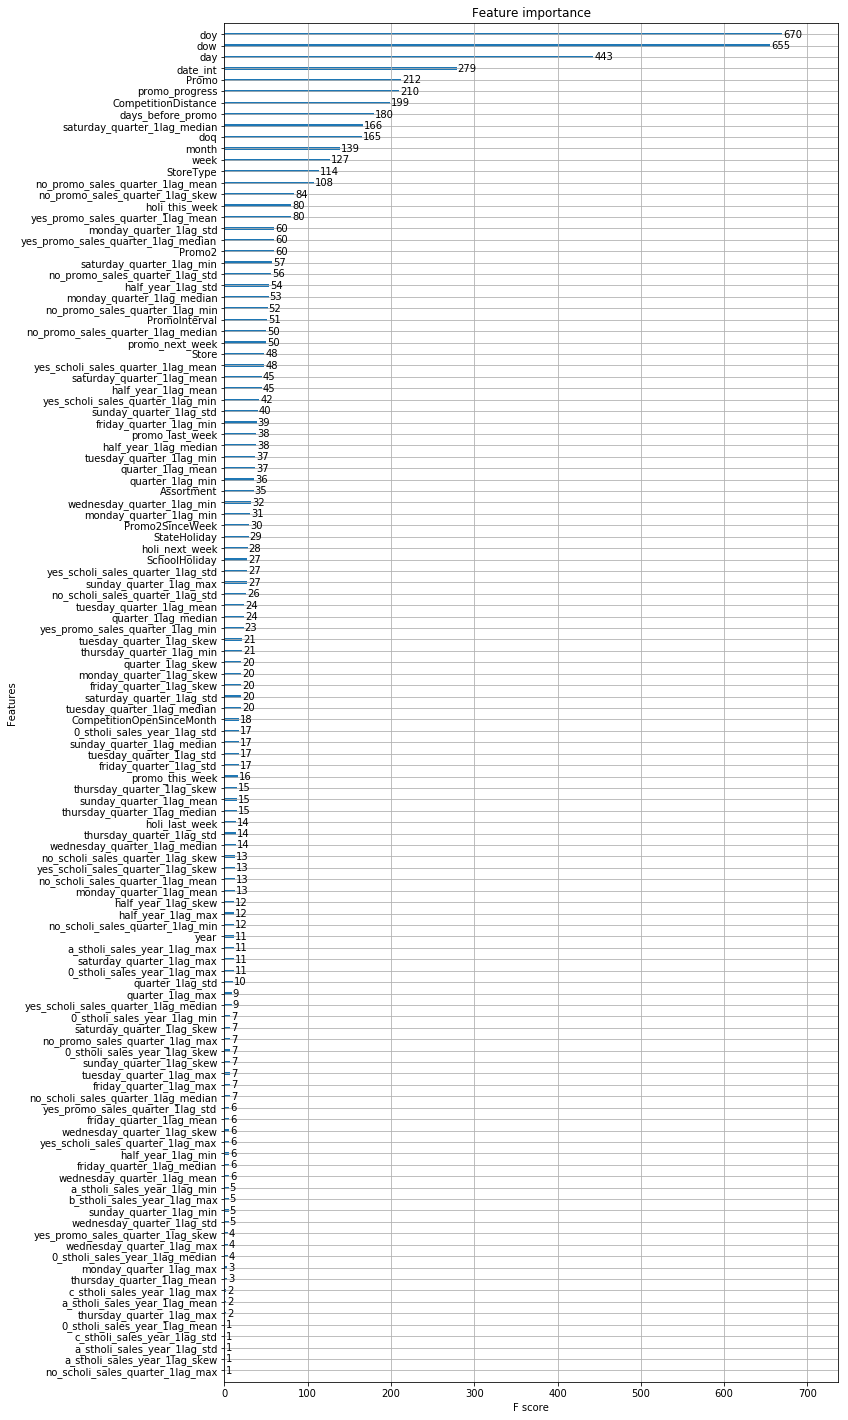

In [242]:
xgb_test(data=data_with_date,
        hight=25,eta=0.05)

rmspe is 0.1462


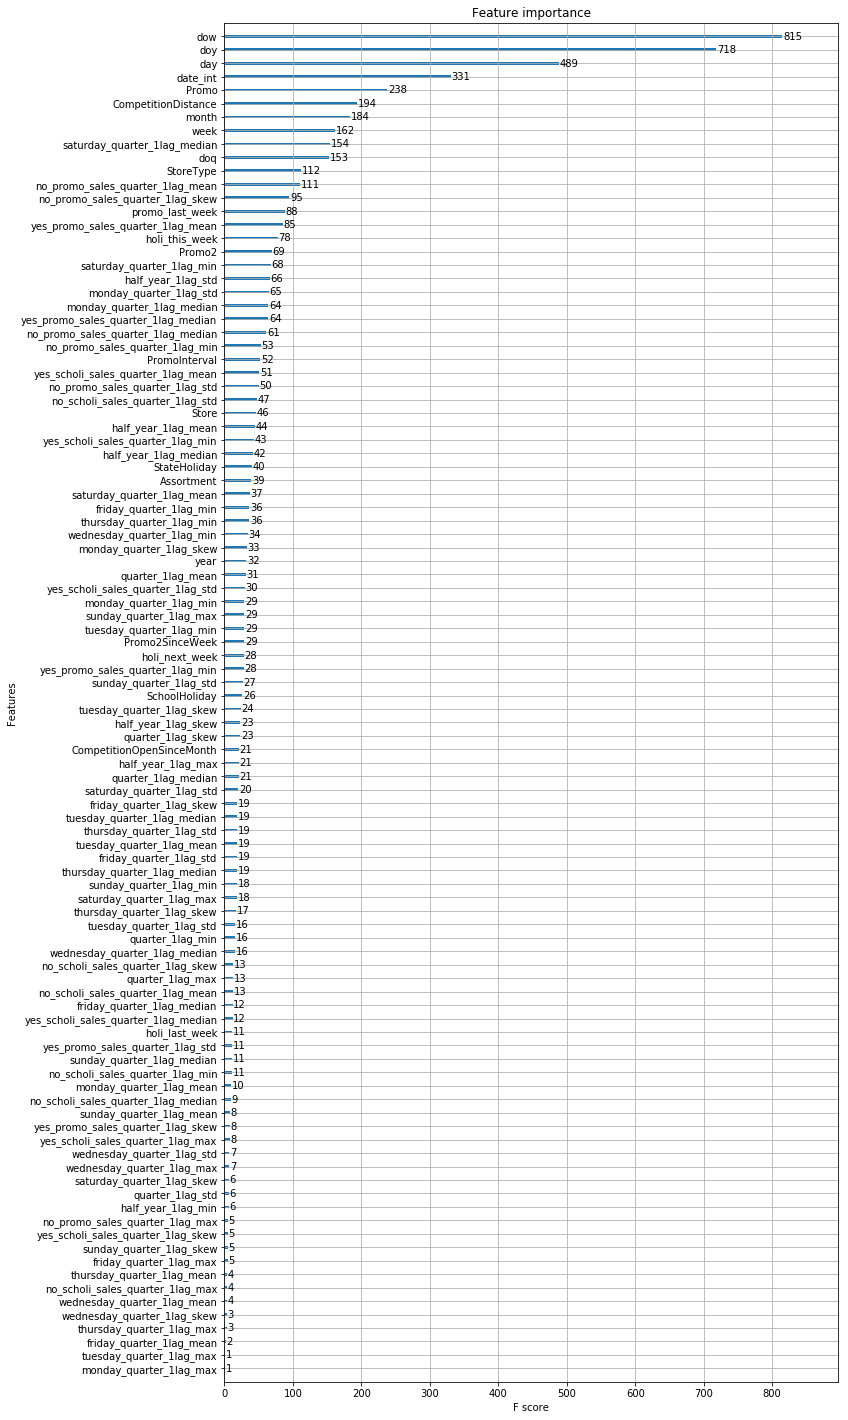

In [243]:
weak_col = eng_feat['sth_col']+eng_feat['promo_notice'][:2]+\
            eng_feat['promo_prog']
xgb_test(data=data_with_date.drop(weak_col,axis=1),
        hight=25,eta=0.05)

In [244]:
data.keys()

dict_keys(['train', 'test', 'store', 'submission', 'full'])

In [245]:
data['test'].shape

(41088, 9)

In [246]:
data_with_date[data_with_date.Id!=0].shape

(35093, 136)

rmspe is 0.1534


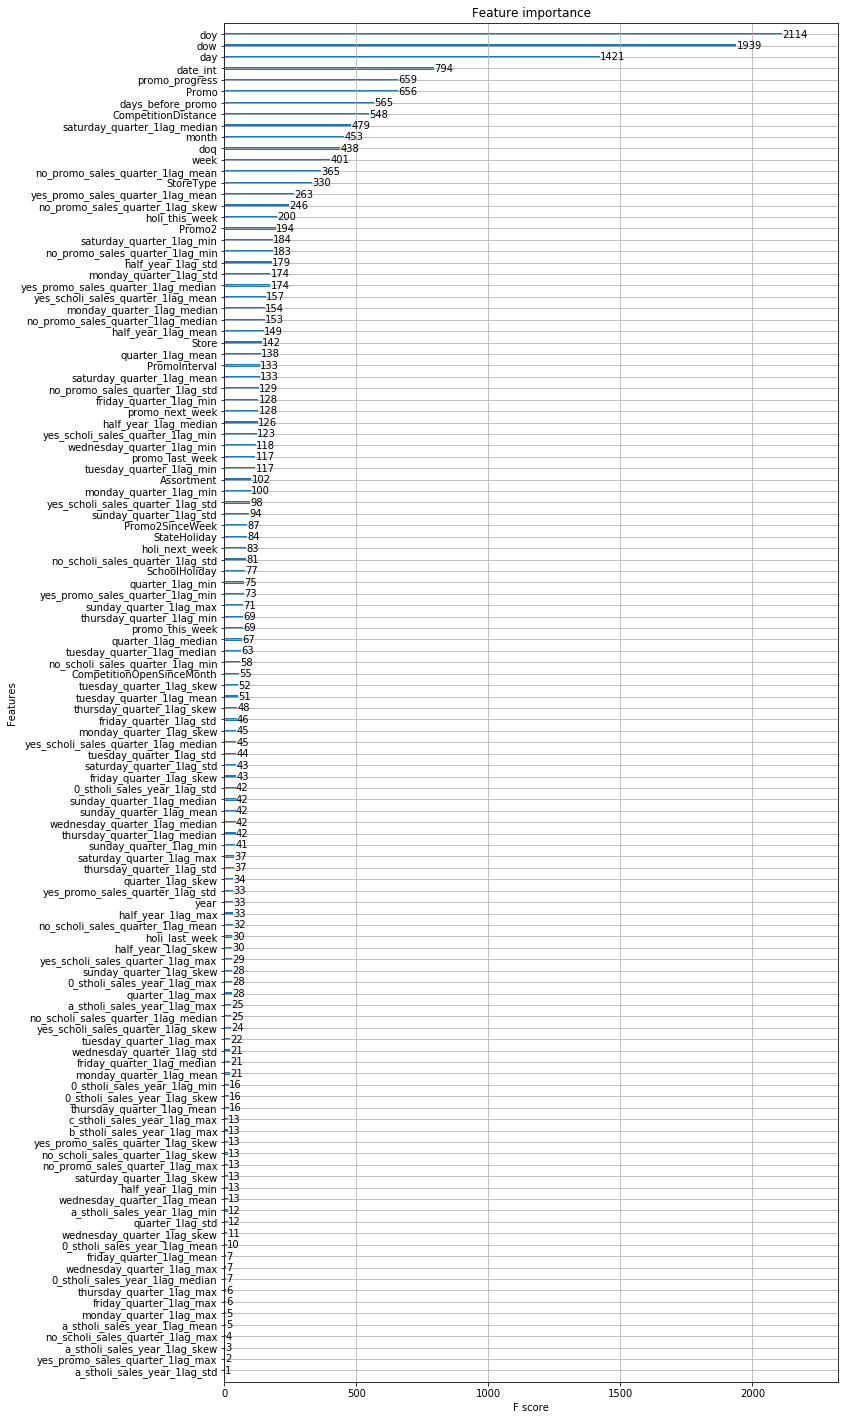

In [247]:
xgb_test(data=data_with_date,hight=25,eta=0.015,nround=300)

rmspe is 0.1440


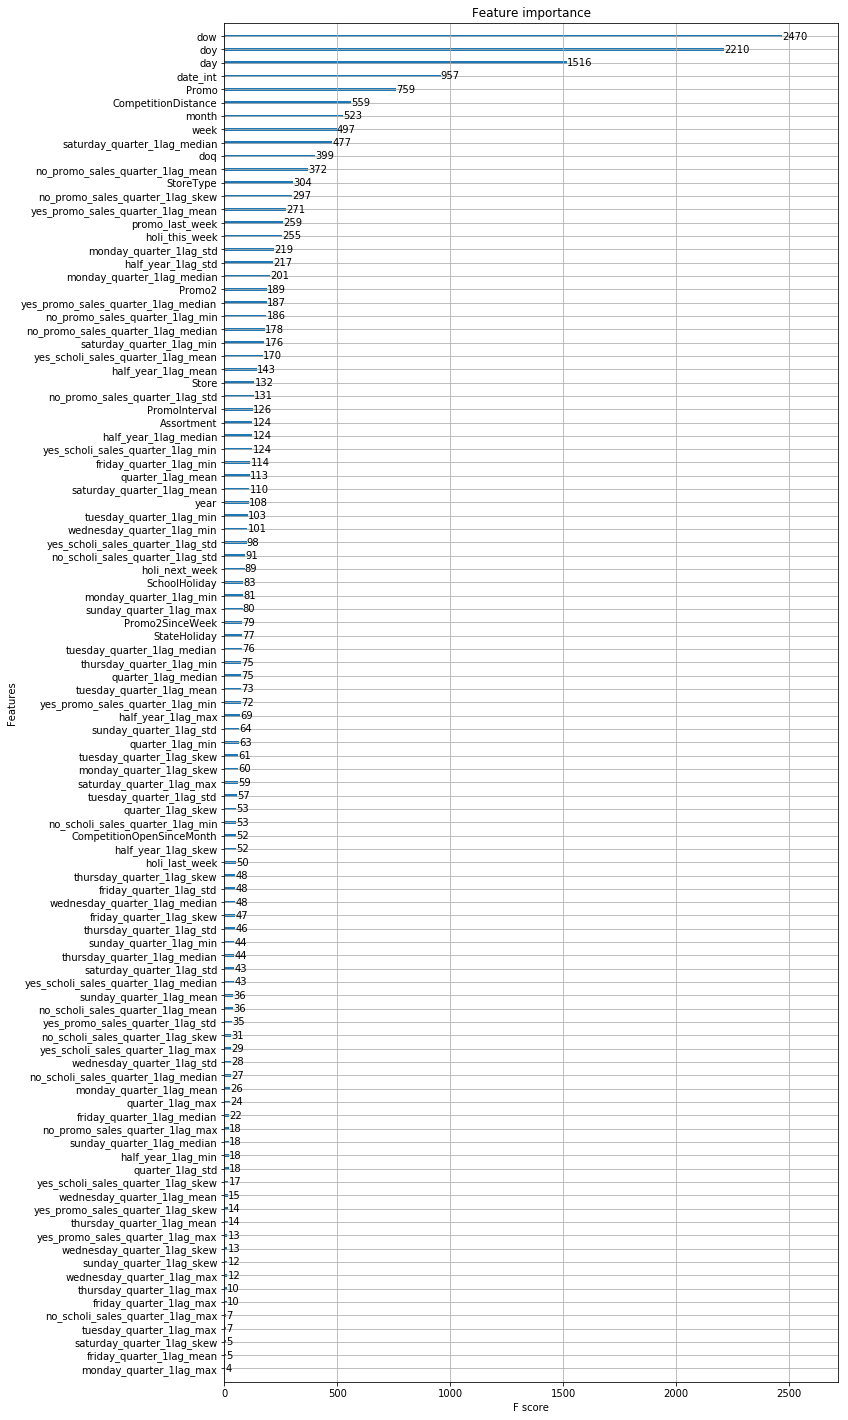

In [248]:
weak_col = eng_feat['sth_col']+eng_feat['promo_notice'][:2]+\
            eng_feat['promo_prog']
xgb_test(data=data_with_date.drop(weak_col,axis=1),
        hight=25,eta=0.015,nround=300)

In [250]:
data_with_date.columns.tolist()

['Date',
 'DayOfWeek',
 'Id',
 'Open',
 'Promo',
 'Sales',
 'SchoolHoliday',
 'StateHoliday',
 'Store',
 'year',
 'month',
 'dow',
 'doy',
 'quarter',
 'day',
 'week',
 'date_int',
 'doq',
 'half_year',
 'quarter_1lag_max',
 'quarter_1lag_min',
 'quarter_1lag_mean',
 'quarter_1lag_median',
 'quarter_1lag_skew',
 'quarter_1lag_std',
 'half_year_1lag_max',
 'half_year_1lag_min',
 'half_year_1lag_mean',
 'half_year_1lag_median',
 'half_year_1lag_skew',
 'half_year_1lag_std',
 'no_scholi_sales_quarter_1lag_max',
 'no_scholi_sales_quarter_1lag_min',
 'no_scholi_sales_quarter_1lag_mean',
 'no_scholi_sales_quarter_1lag_median',
 'no_scholi_sales_quarter_1lag_skew',
 'no_scholi_sales_quarter_1lag_std',
 'yes_scholi_sales_quarter_1lag_max',
 'yes_scholi_sales_quarter_1lag_min',
 'yes_scholi_sales_quarter_1lag_mean',
 'yes_scholi_sales_quarter_1lag_median',
 'yes_scholi_sales_quarter_1lag_skew',
 'yes_scholi_sales_quarter_1lag_std',
 '0_stholi_sales_year_1lag_max',
 '0_stholi_sales_year_1lag_min

In [259]:
non_decomo = data_with_date[['Date',
 'DayOfWeek',
 'Id',
 'Promo',
 'Sales',
 'SchoolHoliday',
 'StateHoliday',
 'Store',
 'year',
 'month',
 'dow',
 'doy',
 'quarter',
 'day',
 'week',
 'date_int',
 'doq',
 'half_year','CompetitionDistance',
 'StoreType',
 'Assortment',
 'CompetitionOpenSinceMonth',
 'Promo2',
 'Promo2SinceWeek',
 'PromoInterval']]

rmspe is 0.1591


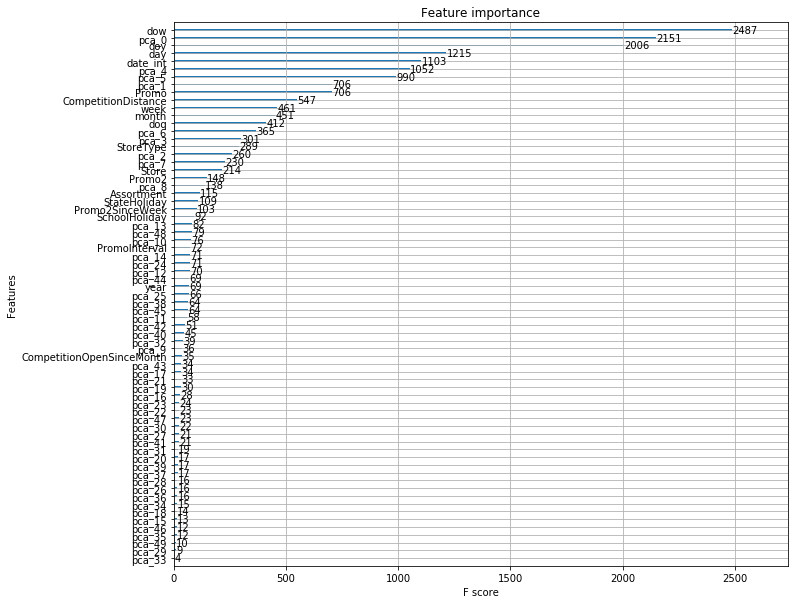

In [283]:
#20,-7
n_components=50
pca = PCA(n_components=n_components,random_state=55)
sales_info = pca.fit_transform(data_with_date.iloc[:,20:-7])
sales_info = pd.DataFrame(sales_info,columns=['pca_{}'.format(i) for i in range(n_components)])
non_decomo.reset_index(drop=True,inplace=True)
pca_data = pd.concat([non_decomo,sales_info],axis=1)
xgb_test(pca_data,eta=0.015,nround=300)

rmspe is 0.1626


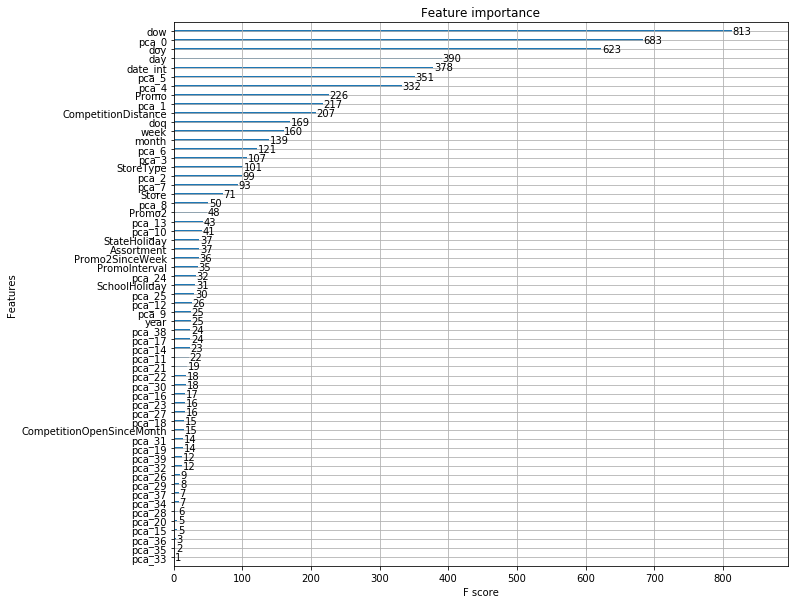

In [277]:
n_components=25
ica = FastICA(n_components=n_components)
ica_info = ica.fit_transform(data_with_date.iloc[:,20:-7])
ica_info = pd.DataFrame(ica_info,columns=['ica_{}'.format(i) for i in range(n_components)])
non_decomo.reset_index(drop=True,inplace=True)
ica_data = pd.concat([non_decomo,sales_info],axis=1)
xgb_test(ica_data,eta=0.05)